## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
import statsmodels.api as sm

## Utils

### Plot

In [2]:
def plot_time_series(T, title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(T)

In [3]:
def plot_time_series_with_discord(T, indices, title):
    plt.figure(figsize=(20, 5))
    plt.plot(T)
    for i in indices:
        plt.plot(i, T[i], 'ro')
    plt.title(title)
    plt.show()

In [4]:
def get_statistical_measures(T):
    return {
        'mean': np.mean(T),
        'median': np.median(T),
        'std': np.std(T),
        'var': np.var(T),
        'min': np.min(T),
        'max': np.max(T),
        'skew': pd.Series(T).skew(),
        'kurtosis': pd.Series(T).kurtosis(),
        'quantile_25': np.quantile(T, 0.25),
        'quantile_50': np.quantile(T, 0.50),
        'quantile_75': np.quantile(T, 0.75),
        'quantile_90': np.quantile(T, 0.90),
    }

In [5]:
def plot_autocorrelation(T, title, max_lag):
    autocorrelation = sm.tsa.acf(T, nlags=max_lag)
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.xlabel('Lag')
    plt.plot(autocorrelation)

In [6]:
def plot_periodogram(T, title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    f, Pxx_den = signal.periodogram(T)
    plt.semilogy(f, Pxx_den)
    plt.xlabel('Frequency')
    plt.ylabel('PSD')
    plt.show()

In [7]:
def plot_boxplot(T, title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    sns.boxplot(T, orient='h')
    plt.show()

In [8]:
def plot_moving_average(T, title, window_size):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(pd.Series(T).rolling(window=window_size).mean())
    plt.xlabel('Time')
    plt.show()

In [9]:
def plot_cross_correlation(T, title, max_lag):
    sT = pd.Series(T)
    res = np.zeros(max_lag)
    for lag in range(max_lag):
        if lag == 0:
            res[0] = 1
        else:
            res[lag] = sT.corr(sT.shift(lag))

    plt.figure(figsize=(20, 5))
    plt.stem(np.arange(max_lag), res)
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.title(title)
    plt.show()

In [10]:
def plot_dft(T, title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(np.abs(np.fft.fft(T)))
    plt.xlabel('Frequency')
    plt.show()

In [11]:
def plot_spectrogram(T, title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    f, t, Sxx = signal.spectrogram(T)
    plt.pcolormesh(t, f, Sxx)
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.show()

### DRAG

In [12]:
def distance(subseq1, subseq2):
    if np.std(subseq1) == 0 or np.std(subseq2) == 0:
        return float('inf')

    z_normalized_subseq1 = (subseq1 - np.mean(subseq1)) / np.std(subseq1)
    z_normalized_subseq2 = (subseq2 - np.mean(subseq2)) / np.std(subseq2)

    euclidean_distance = np.linalg.norm(z_normalized_subseq1 - z_normalized_subseq2)

    return euclidean_distance

In [13]:
def candidate_selection(T, L, r):
    C = []

    for i in range(1, (len(T) - L + 1) + 1):
        is_candidate = True

        for j in C:
            if abs(i - j) >= L and i+L < len(T) and j+L < len(T):
                if distance(T[i:i+L], T[j:j+L]) < r:
                    C.remove(j)
                    is_candidate = False

        if is_candidate:
            C.append(i)

    if C:
        return C
    else:
        return None

In [14]:
def discord_refinement(C, T, L, r):
    D = []

    for i in range(1, (len(T) - L + 1) + 1):
        is_discord = True
        min_candidate_distance = float('inf') if C else 0
        j_min = -1

        for j in C:
            if abs(i - j) >= L and i+L < len(T) and j+L < len(T):
                d = distance(T[i:i+L], T[j:j+L])
                if d < r:
                    C.remove(j)
                    is_discord = False
                else:
                    min_candidate_distance = min(min_candidate_distance, d)
                    if min_candidate_distance == d:
                        j_min = j

        if is_discord and min_candidate_distance != float('inf'):
            if not any(j_min in sublist for sublist in D):
                D.append((j_min, min_candidate_distance))
    D.sort(key=lambda tup: tup[1], reverse=True)
    return D

In [15]:
def DRAG(T, L, r):
    C = candidate_selection(T, L, r)
    if not C:
        return None, None
    D = discord_refinement(C, T, L, r)
    return D

### MERLIN

In [16]:
def MERLIN(T, MinL, MaxL):
    distances = np.full(MaxL - MinL + 1, 0.0)
    distances[0] = -1 * float('inf')
    indices = np.zeros(MaxL - MinL + 1, dtype=int)
    lengths = np.arange(MinL, MaxL + 1)

    r = 2 * np.sqrt(MinL)

    while distances[0] < 0:
        D = DRAG(T, MinL, r)
        if D == []:
            r = r * 0.5
        else:
            indices[0], distances[0] = D[0]
            r = r * 0.5

    for i in range(MinL + 1, MinL + 5):
        if i > MaxL - MinL:
            break
        while distances[i] < 0:
            r = distances[i - 1] * 0.99
            D = DRAG(T, lengths[i], r)
            if D == []:
              r = r * 0.99
            else:
              indices[i], distances[i] = D[0]
              r = r * 0.99

    if MaxL - MinL < 5:
        index_delete = np.where(indices == 0)
        indices = np.delete(indices, index_delete, axis=0)
        distances = np.delete(distances, index_delete, axis=0)
        lengths = np.delete(lengths, index_delete, axis=0)

        return indices, lengths, distances

    for i in range(5, MaxL - MinL + 1):
        m = np.mean(distances[i - 5:i])
        s = np.std(distances[i - 5:i])
        r = m - 2 * s
        indices[i], distances[i] = DRAG(T, lengths[i], r)[0]
        while distances[i] < 0:
            D = DRAG(T, lengths[i], r)
            if D == []:
                r = r - s
            else:
                indices[i], distances[i] = D[0]
                r = r - s

    index_delete = np.where(indices == 0)
    indices = np.delete(indices, index_delete, axis=0)
    distances = np.delete(distances, index_delete, axis=0)
    lengths = np.delete(lengths, index_delete, axis=0)

    return indices, lengths, distances

### Evaluation

In [17]:
def evaluate(predictions, ground_truth, T_len):
    successes = 0
    for pred in predictions:
        correct = any(abs(pred - gt) <= 0.01 * T_len for gt in ground_truth)
        if correct:
            successes += 1
    return round((successes / len(predictions)) * 100, 2)

In [18]:
def evaluate_plot(T, MinL_range, ground_thruth):
    performance = []
    for MinL in MinL_range:
        MaxL = MinL + 5
        indices_merlin = MERLIN(T, MinL, MaxL)[0]
        performance.append(evaluate(indices_merlin, ground_thruth, len(T)))
    plt.figure(figsize=(20, 5))
    plt.plot(MinL_range, performance, marker='o')
    plt.xlabel('(MinL, MaxL = MinL + 5)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy evolution of MERLIN')
    plt.show()

## Toy Examples

### Example 1: Constant with 1 anomaly

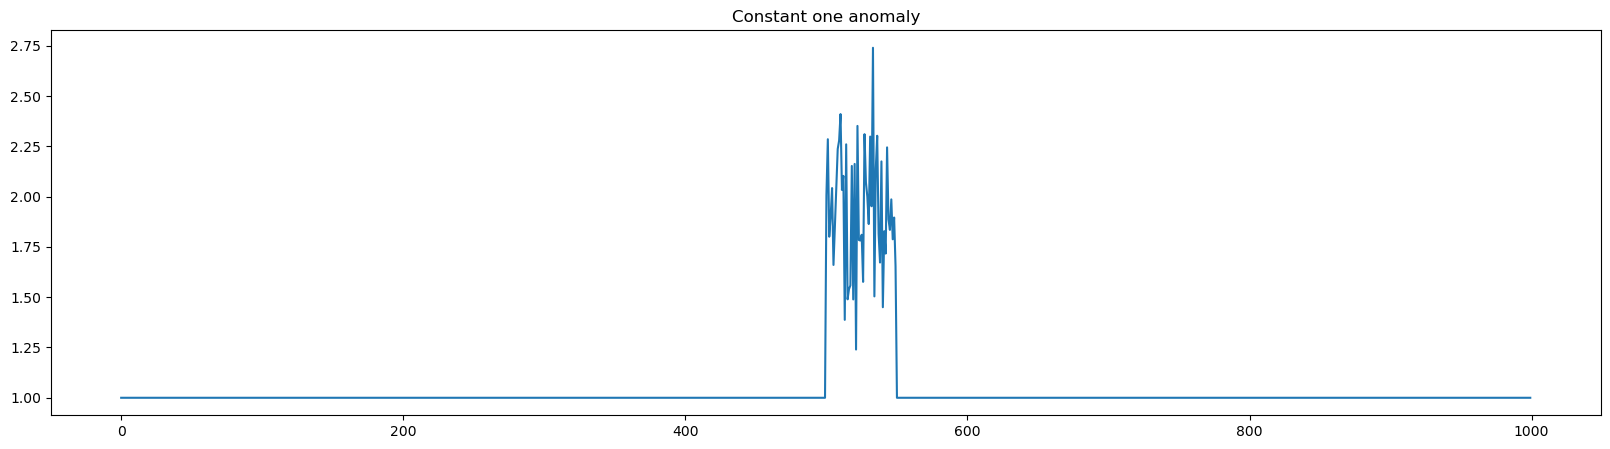

In [19]:
constant_one_anomaly = np.ones(1000)
constant_one_anomaly[500:550] = np.random.normal(2, 0.3, 50)
plot_time_series(constant_one_anomaly, 'Constant one anomaly')

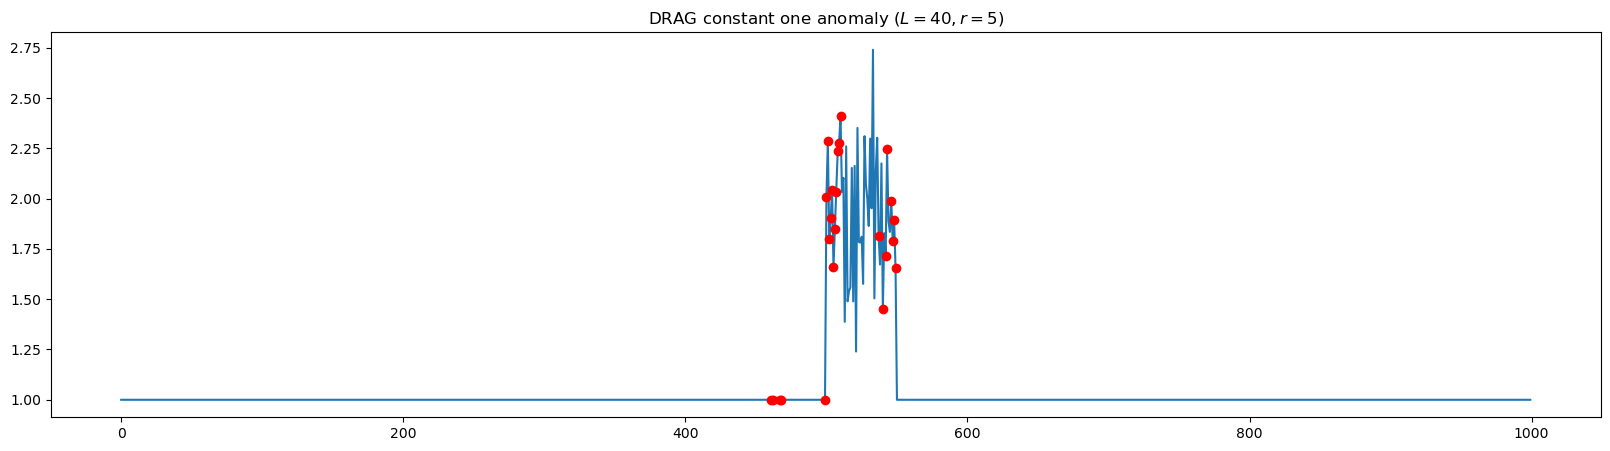

In [20]:
D = DRAG(constant_one_anomaly, 40, 5)
indices_drag_constant_one_anomaly = [elt[0] for elt in D]
plot_time_series_with_discord(constant_one_anomaly, indices_drag_constant_one_anomaly, 'DRAG constant one anomaly ($L=40, r=5$)')

In [21]:
print(f"DRAG: {evaluate(indices_drag_constant_one_anomaly, range(500,551), len(constant_one_anomaly))} %")

DRAG: 83.33 %


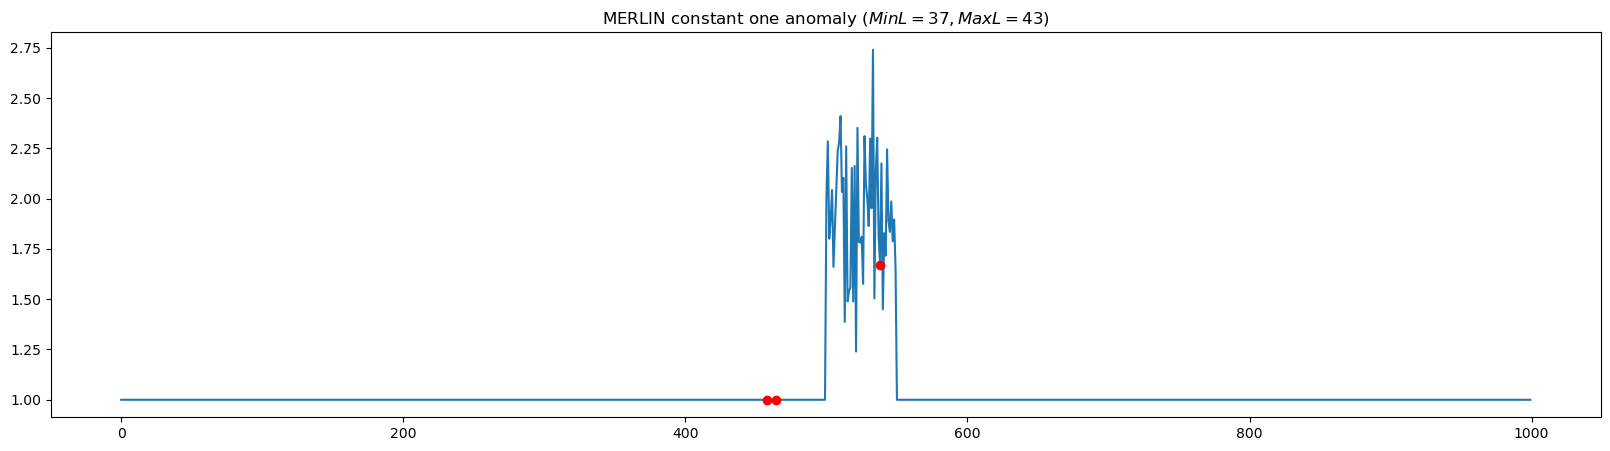

In [22]:
M = MERLIN(constant_one_anomaly, 37, 43)
indices_merlin_constant_one_anomaly = M[0]
plot_time_series_with_discord(constant_one_anomaly, indices_merlin_constant_one_anomaly, 'MERLIN constant one anomaly ($MinL = 37, MaxL = 43$)')

In [23]:
print(f"MERLIN: {evaluate(indices_merlin_constant_one_anomaly, range(500,551), len(constant_one_anomaly))} %")

MERLIN: 33.33 %


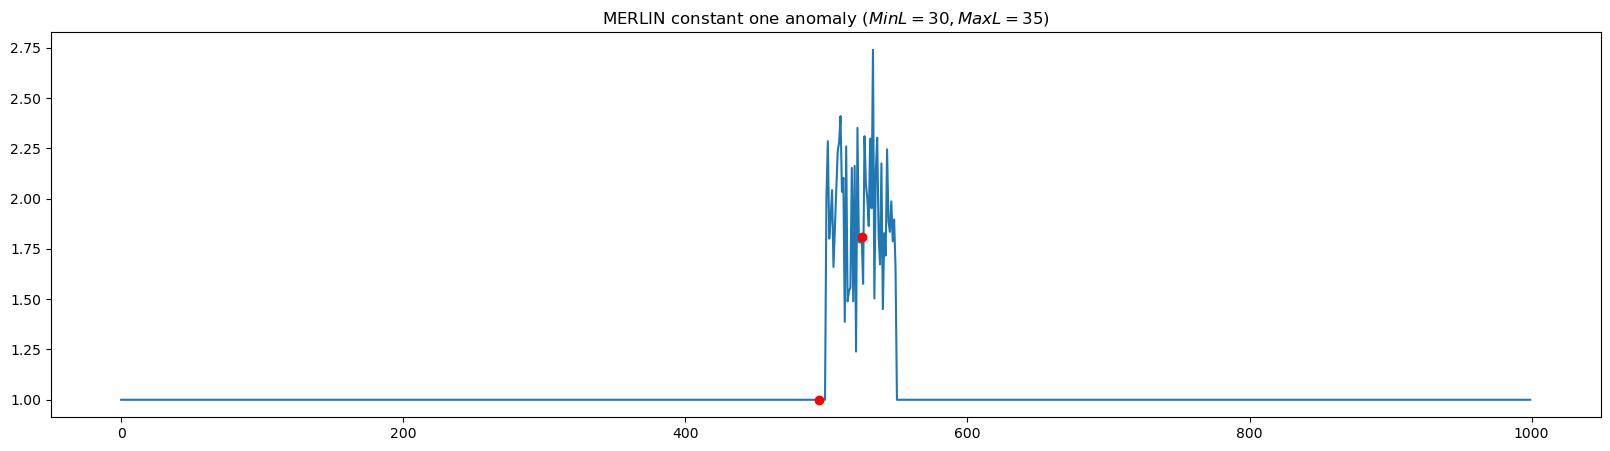

In [24]:
M = MERLIN(constant_one_anomaly, 30, 35)
indices_merlin_constant_one_anomaly = M[0]
plot_time_series_with_discord(constant_one_anomaly, indices_merlin_constant_one_anomaly, 'MERLIN constant one anomaly ($MinL = 30, MaxL = 35$)')

In [25]:
print(f"MERLIN: {evaluate(indices_merlin_constant_one_anomaly, range(500,551), len(constant_one_anomaly))} %")

MERLIN: 100.0 %


In [26]:
#evaluate_plot(constant_one_anomaly, range(30, 40), range(500, 551))

### Example 2: Constant with 2 anomalies

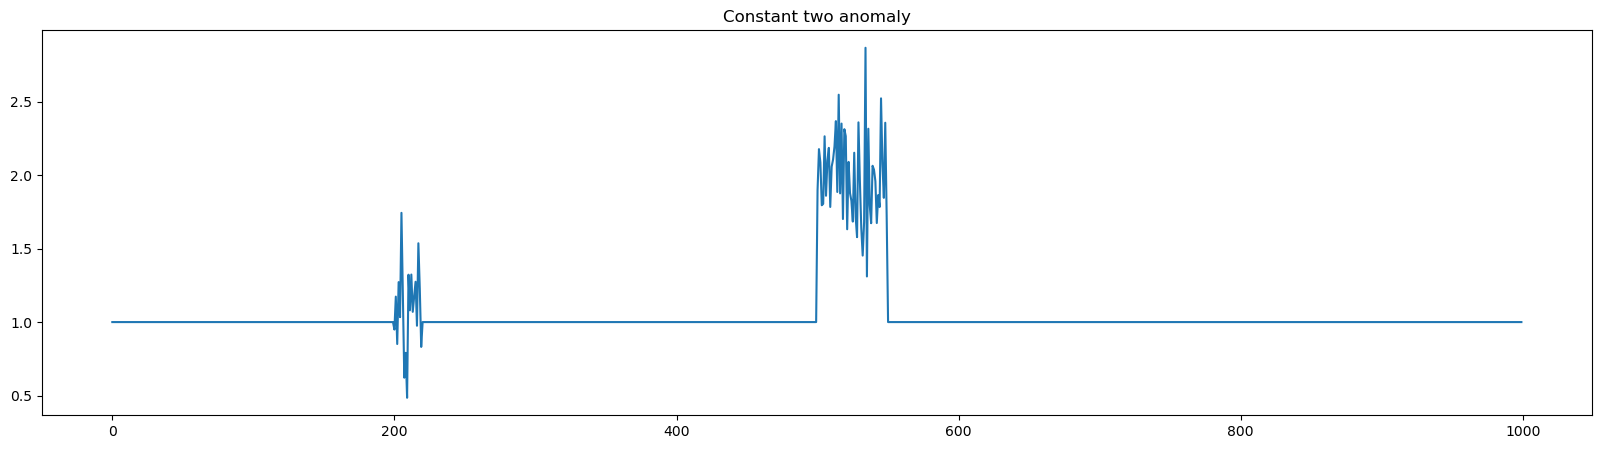

In [27]:
constant_two_anomaly = np.ones(1000)
constant_two_anomaly[500:550] = np.random.normal(2, 0.3, 50)
constant_two_anomaly[200:220] = np.random.normal(1, 0.3, 20)
plot_time_series(constant_two_anomaly, 'Constant two anomaly')

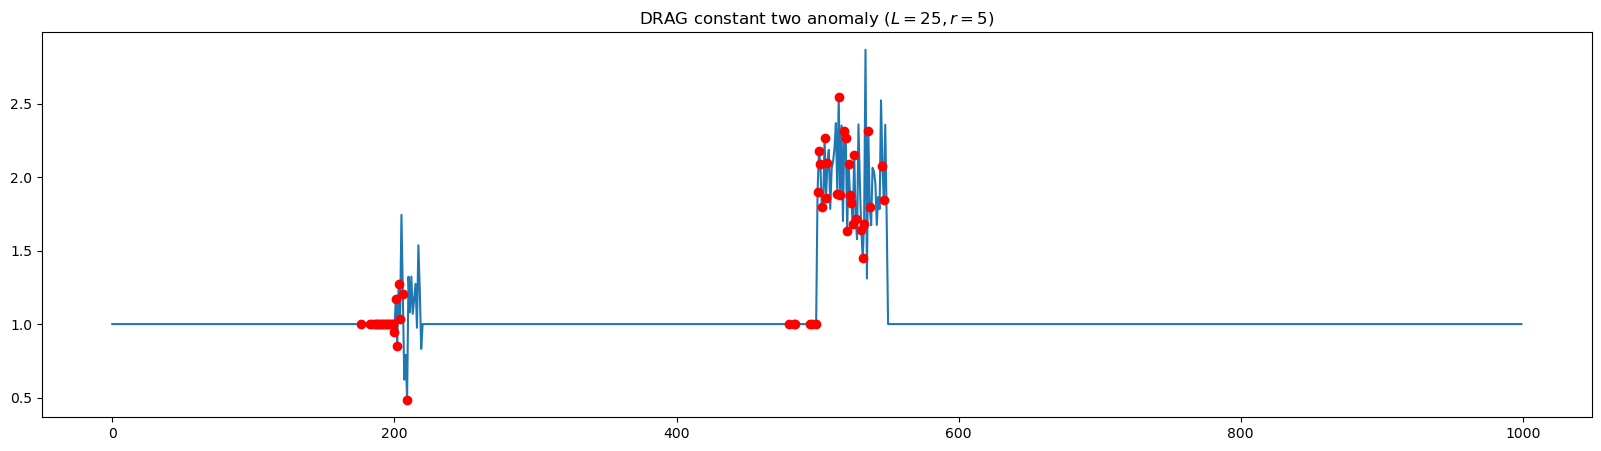

In [28]:
D = DRAG(constant_two_anomaly, 25, 5)
indices_drag_constant_two_anomaly = [elt[0] for elt in D]
plot_time_series_with_discord(constant_two_anomaly, indices_drag_constant_two_anomaly, 'DRAG constant two anomaly ($L=25, r=5$)')

In [29]:
print(f"DRAG: {evaluate(indices_drag_constant_two_anomaly, list(range(200, 221)) + list(range(500, 551)), len(constant_two_anomaly))} %")

DRAG: 82.14 %


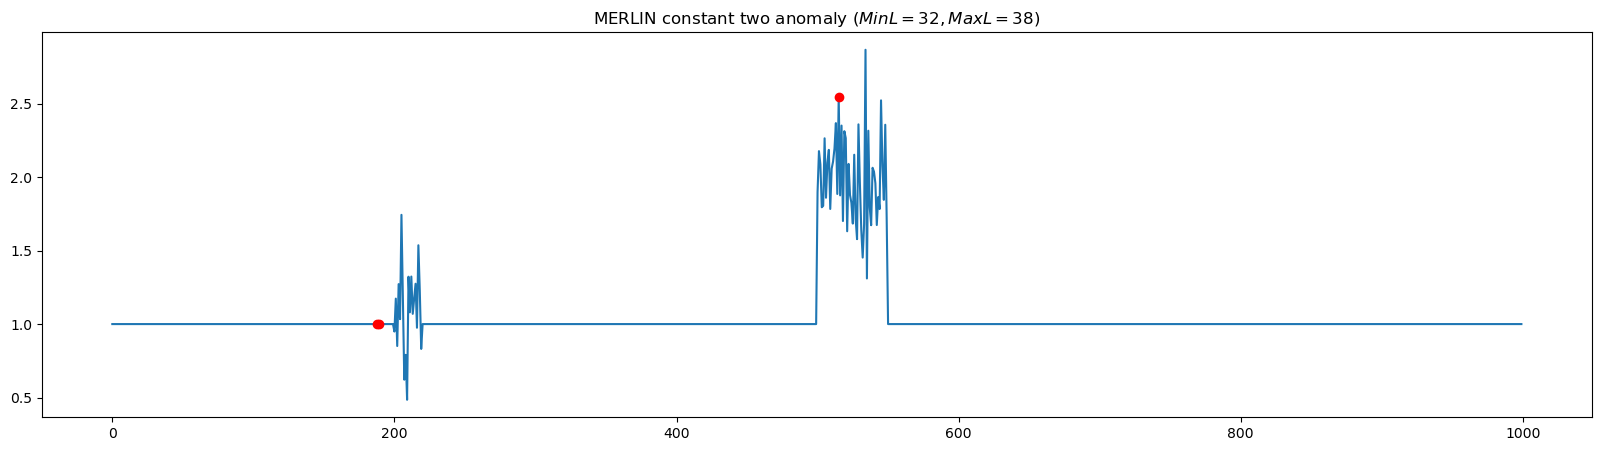

In [30]:
M = MERLIN(constant_two_anomaly, 32, 38)
indices_merlin_constant_two_anomaly = M[0]
plot_time_series_with_discord(constant_two_anomaly, indices_merlin_constant_two_anomaly, 'MERLIN constant two anomaly ($MinL = 32, MaxL = 38$)')

In [31]:
print(f"MERLIN: {evaluate(indices_merlin_constant_two_anomaly, list(range(200, 221)) + list(range(500, 551)), len(constant_two_anomaly))} %")

MERLIN: 33.33 %


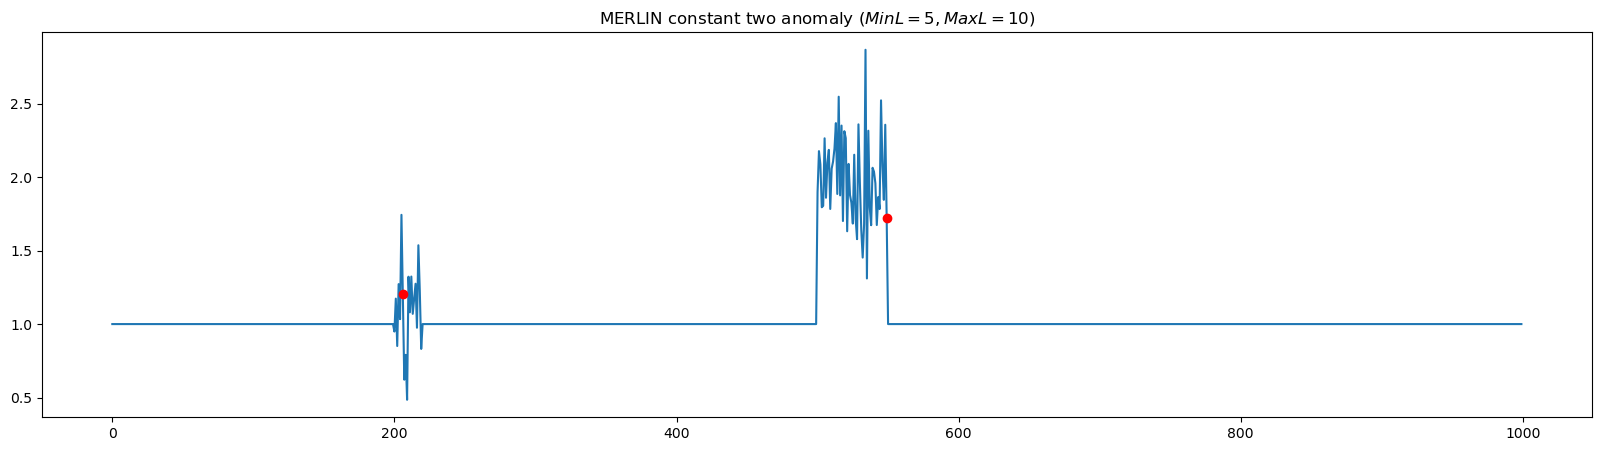

In [32]:
M = MERLIN(constant_two_anomaly, 5, 10)
indices_merlin_constant_two_anomaly = M[0]
plot_time_series_with_discord(constant_two_anomaly, indices_merlin_constant_two_anomaly, 'MERLIN constant two anomaly ($MinL = 5, MaxL = 10$)')

In [33]:
print(f"MERLIN: {evaluate(indices_merlin_constant_two_anomaly, list(range(200, 221)) + list(range(500, 551)), len(constant_two_anomaly))} %")

MERLIN: 100.0 %


In [34]:
#evaluate_plot(constant_two_anomaly, range(5, 15), list(range(200, 221)) + list(range(500, 551)))

### Example 3: Sinusoidal with 1 anomaly

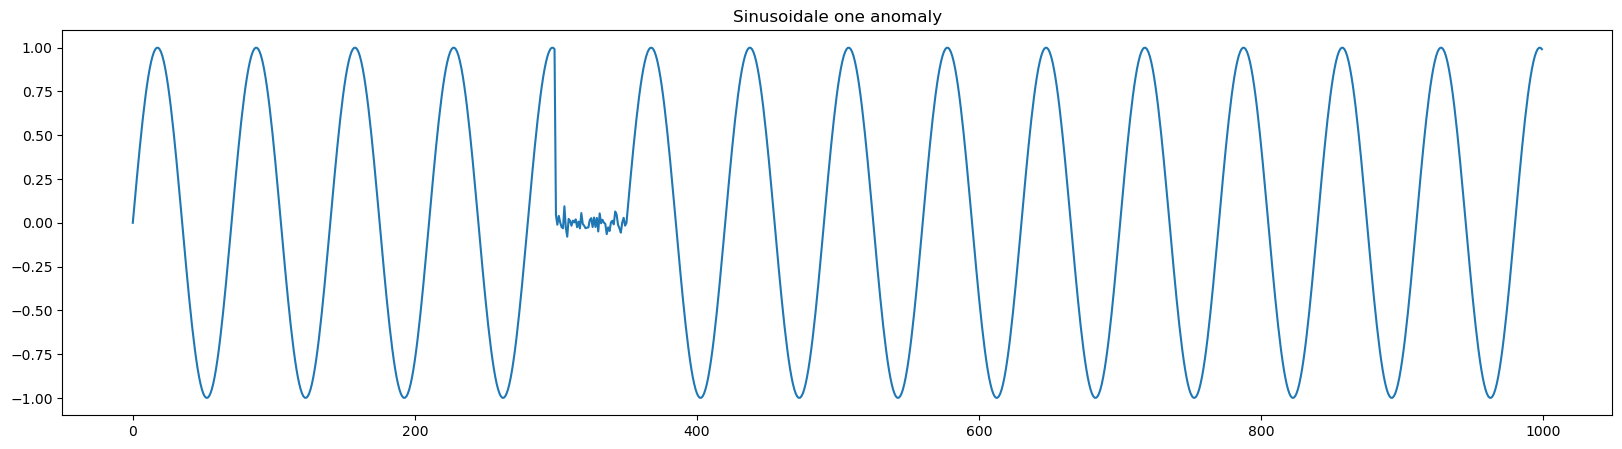

In [35]:
sinusoidale_one_anomaly = np.sin(np.arange(0, 1000) * (2 * np.pi / 70))
sinusoidale_one_anomaly[300:350] = np.random.normal(0, 0.03, 50)
plot_time_series(sinusoidale_one_anomaly, 'Sinusoidale one anomaly')

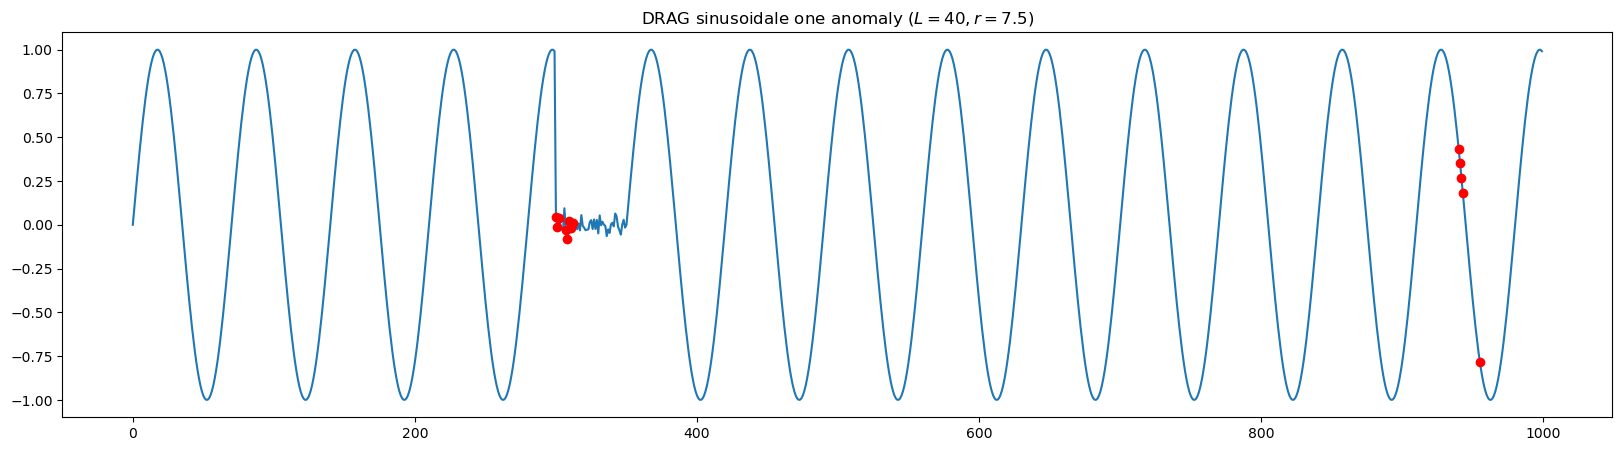

In [36]:
D = DRAG(sinusoidale_one_anomaly, 40, 7.5)
indices_drag_sinusoidale_one_anomaly = [elt[0] for elt in D]
plot_time_series_with_discord(sinusoidale_one_anomaly, indices_drag_sinusoidale_one_anomaly, 'DRAG sinusoidale one anomaly ($L=40, r=7.5$)')

In [37]:
print(f"DRAG: {evaluate(indices_drag_sinusoidale_one_anomaly, range(300,351), len(sinusoidale_one_anomaly))} %")

DRAG: 61.54 %


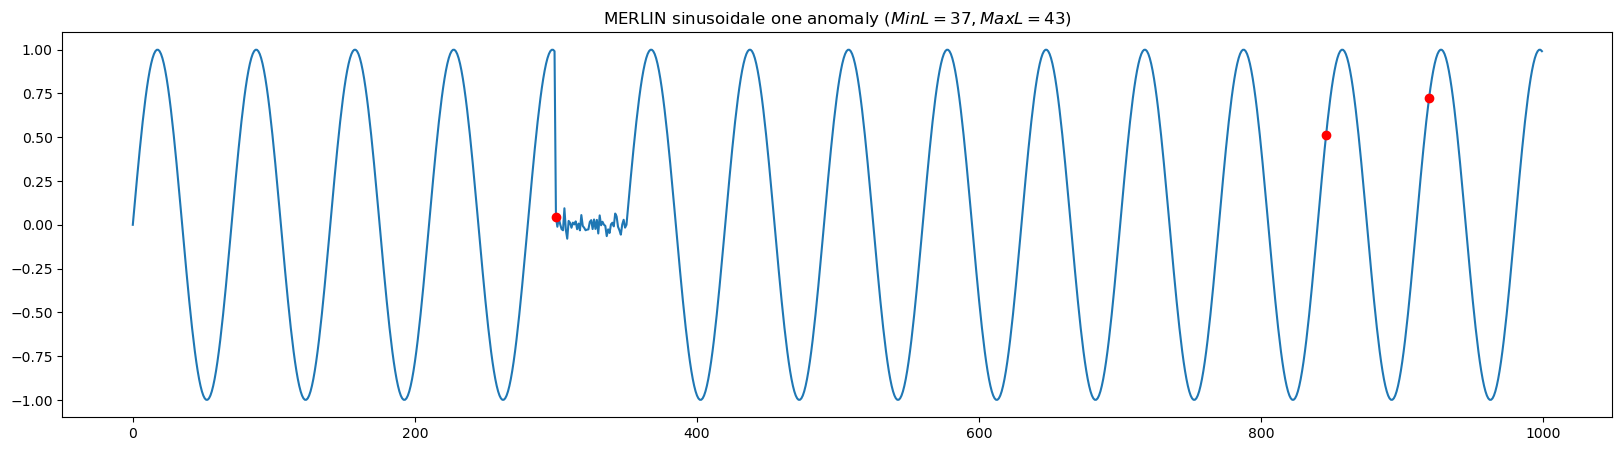

In [38]:
M = MERLIN(sinusoidale_one_anomaly, 37, 43)
indices_merlin_sinusoidale_one_anomaly = M[0]
plot_time_series_with_discord(sinusoidale_one_anomaly, indices_merlin_sinusoidale_one_anomaly, 'MERLIN sinusoidale one anomaly ($MinL = 37, MaxL = 43$)')

In [39]:
print(f"MERLIN: {evaluate(indices_merlin_sinusoidale_one_anomaly, range(300,351), len(sinusoidale_one_anomaly))} %")

MERLIN: 33.33 %


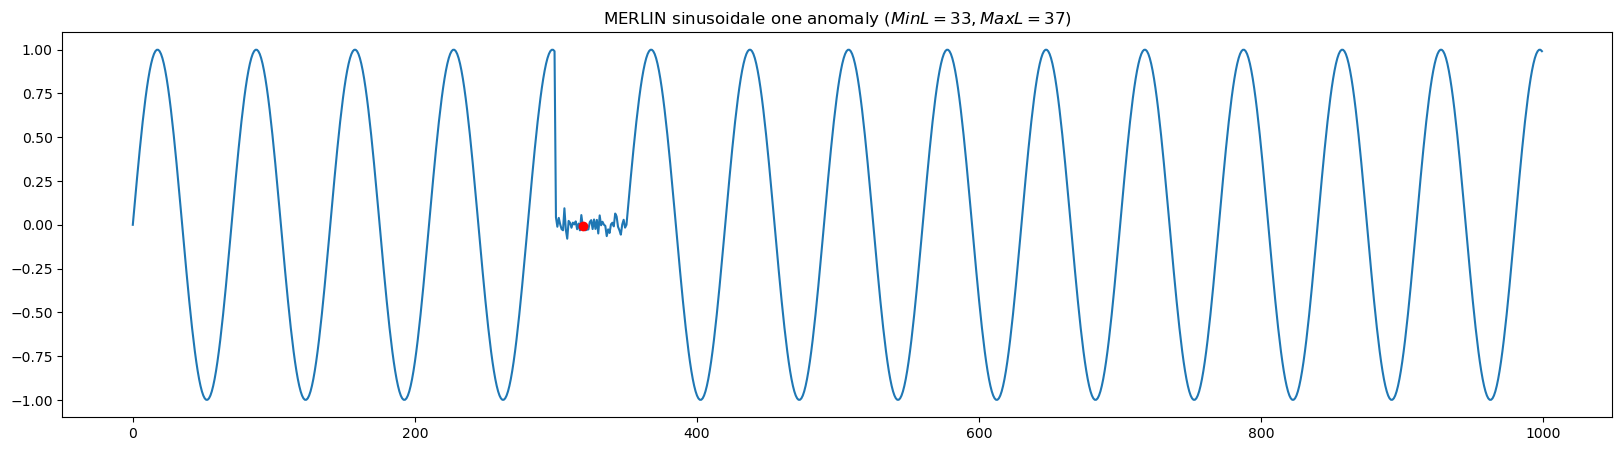

In [40]:
M = MERLIN(sinusoidale_one_anomaly, 33, 37)
indices_merlin_sinusoidale_one_anomaly = M[0]
plot_time_series_with_discord(sinusoidale_one_anomaly, indices_merlin_sinusoidale_one_anomaly, 'MERLIN sinusoidale one anomaly ($MinL = 33, MaxL = 37$)')

In [41]:
print(f"MERLIN: {evaluate(indices_merlin_sinusoidale_one_anomaly, range(300,351), len(sinusoidale_one_anomaly))} %")

MERLIN: 100.0 %


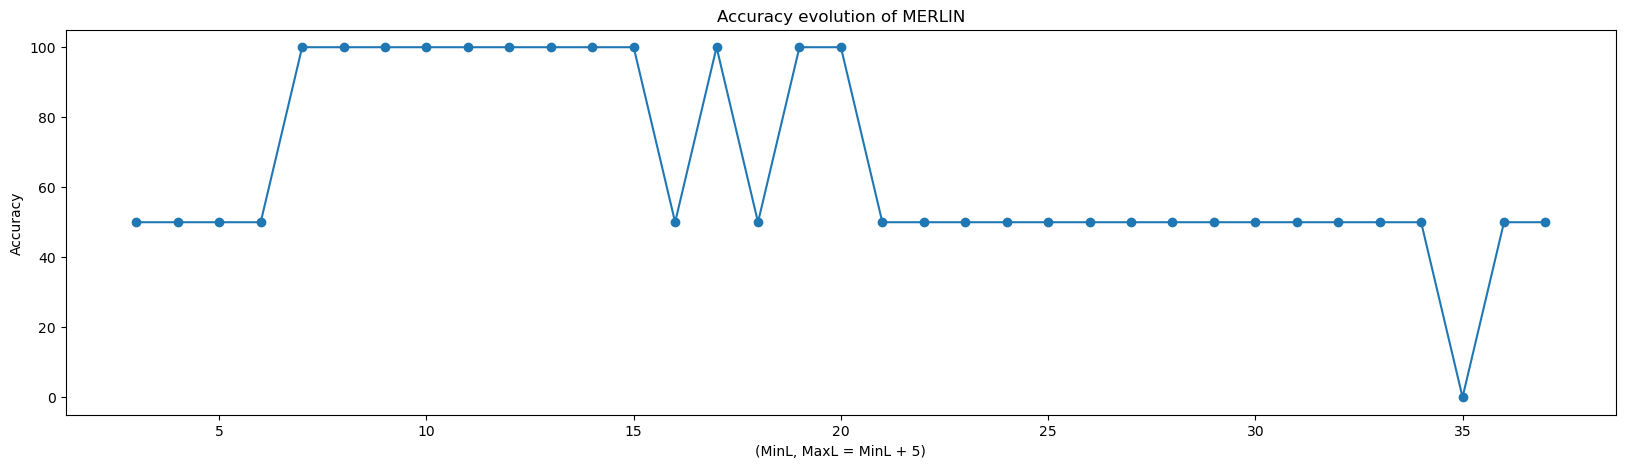

In [42]:
evaluate_plot(sinusoidale_one_anomaly, range(3, 38), range(300,351)) # takes too much time (around 3 hours)

# Real Examples

## New York City Taxi

### Data Analysis

In [43]:
nyc_taxi = pd.read_csv('nyc_taxi.csv')
nyc_taxi = nyc_taxi[(nyc_taxi['timestamp'] >= '2014-10-31') & (nyc_taxi['timestamp'] <= '2014-11-30')]

In [44]:
nyc_taxi.columns

Index(['timestamp', 'value'], dtype='object')

In [45]:
nyc_taxi.head()

,timestamp,value
5856,2014-10-31 00:00:00,19957
5857,2014-10-31 00:30:00,16881
5858,2014-10-31 01:00:00,13588
5859,2014-10-31 01:30:00,10958
5860,2014-10-31 02:00:00,9119


In [46]:
nyc_taxi.shape

(1440, 2)

In [47]:
get_statistical_measures(nyc_taxi['value'])

{'mean': 15631.294444444444,
 'median': 17398.0,
 'std': 7073.885291904634,
 'var': 50039853.12302471,
 'min': 1683,
 'max': 39197,
 'skew': -0.4437635856940883,
 'kurtosis': -0.6907290667430983,
 'quantile_25': 10828.5,
 'quantile_50': 17398.0,
 'quantile_75': 20300.75,
 'quantile_90': 24071.500000000004}

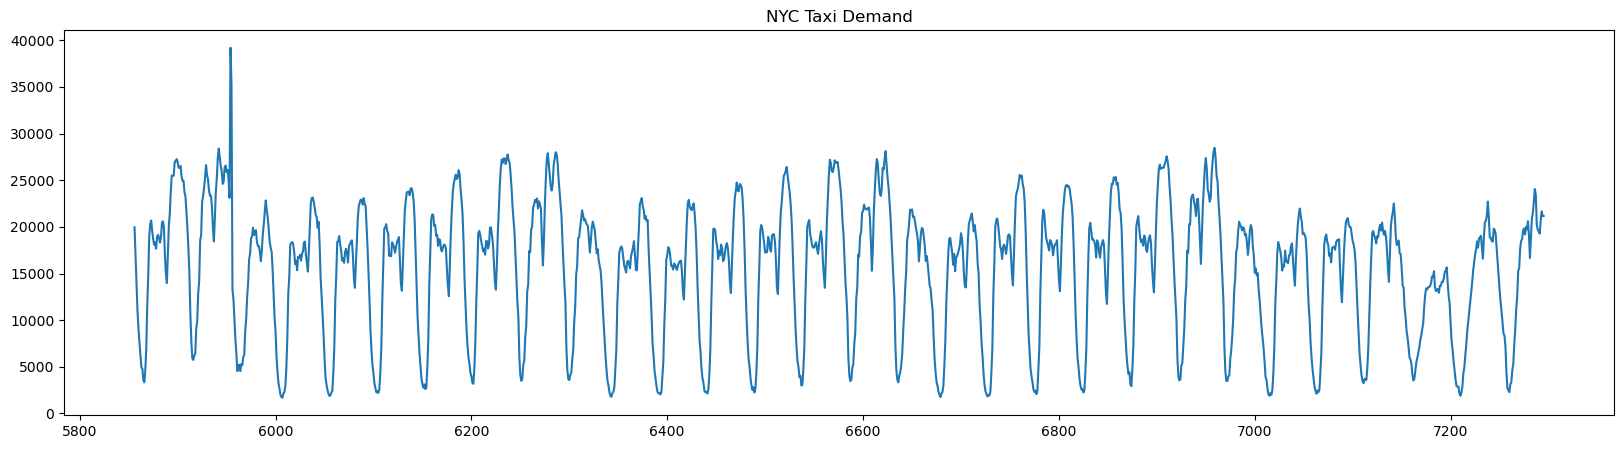

In [48]:
plot_time_series(nyc_taxi['value'], 'NYC Taxi Demand')

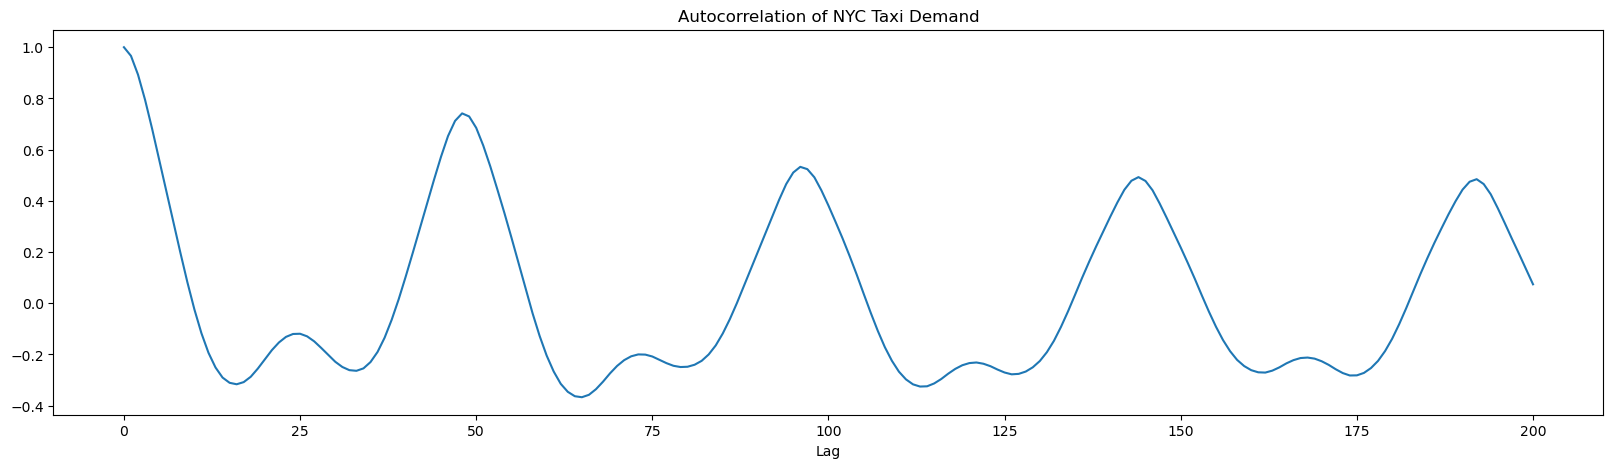

In [49]:
plot_autocorrelation(nyc_taxi['value'], 'Autocorrelation of NYC Taxi Demand', 200)

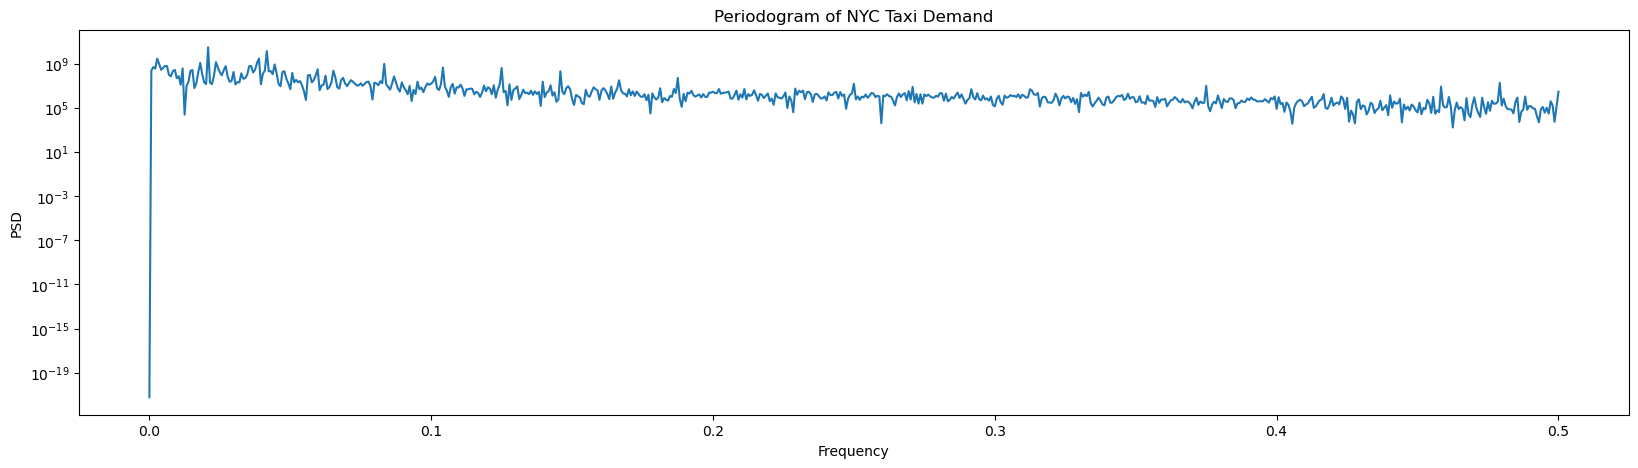

In [50]:
plot_periodogram(nyc_taxi['value'], 'Periodogram of NYC Taxi Demand')

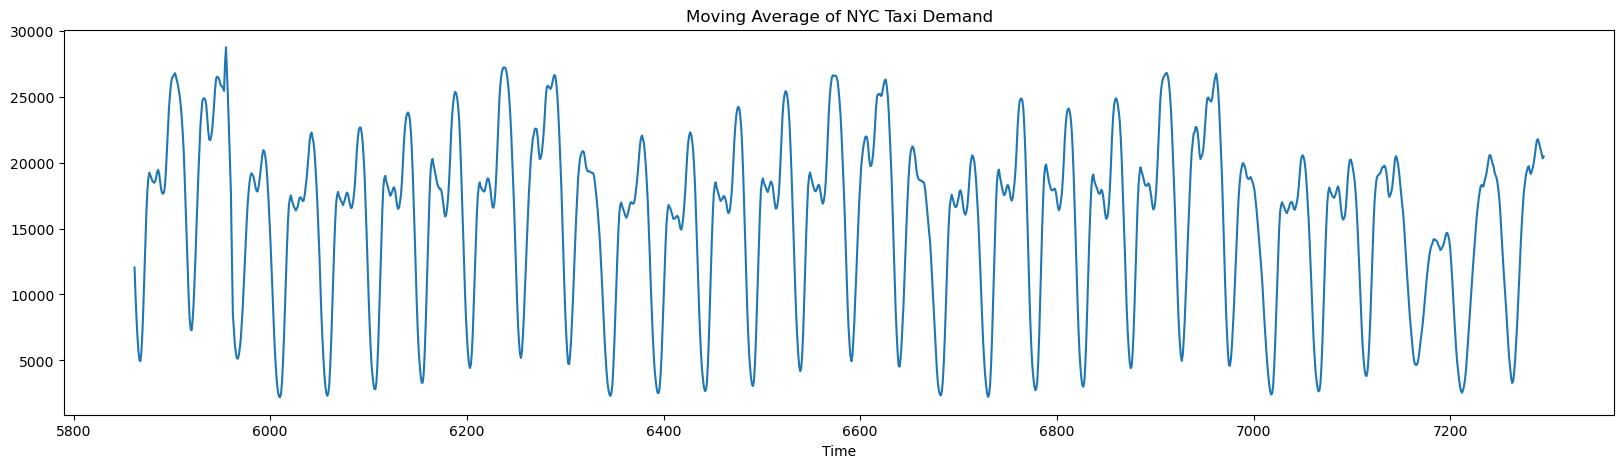

In [51]:
plot_moving_average(nyc_taxi['value'], 'Moving Average of NYC Taxi Demand', 7)

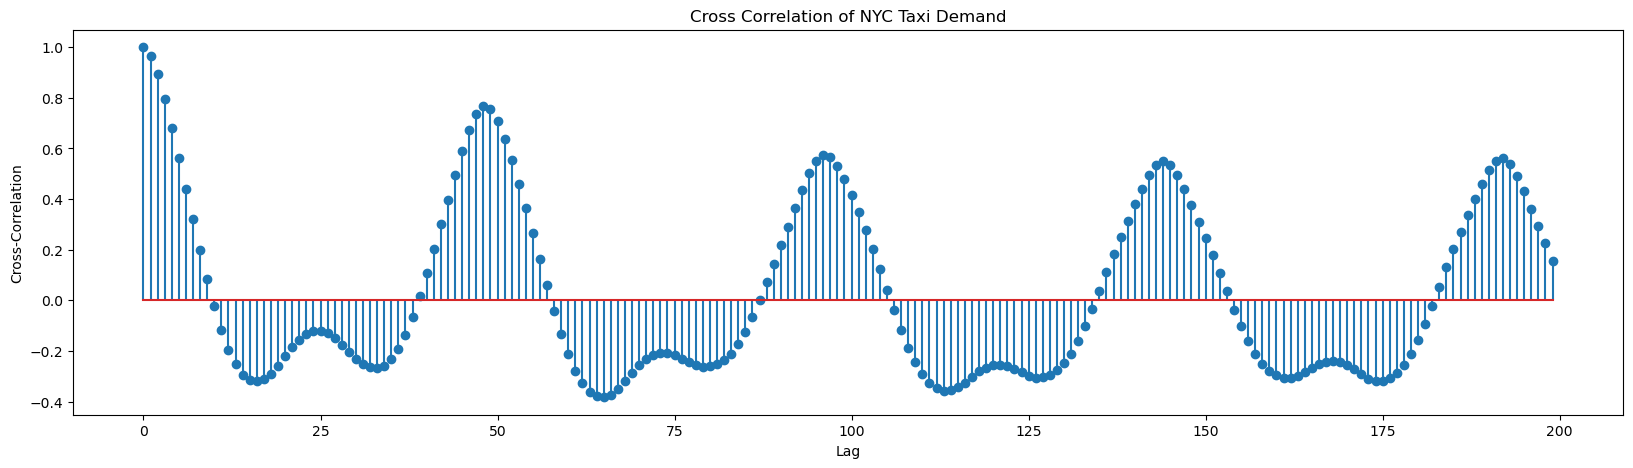

In [52]:
plot_cross_correlation(nyc_taxi['value'], 'Cross Correlation of NYC Taxi Demand', 200)

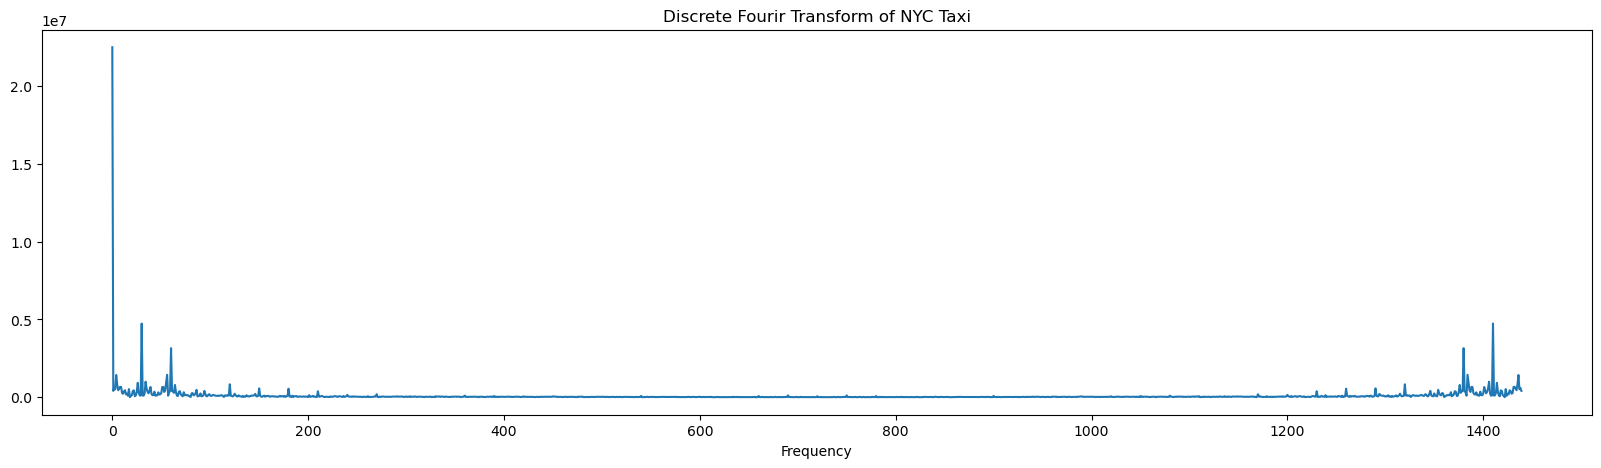

In [53]:
plot_dft(nyc_taxi['value'], 'Discrete Fourir Transform of NYC Taxi')

### Merlin

In [54]:
nyc_taxi_ts = nyc_taxi['value'].to_numpy()

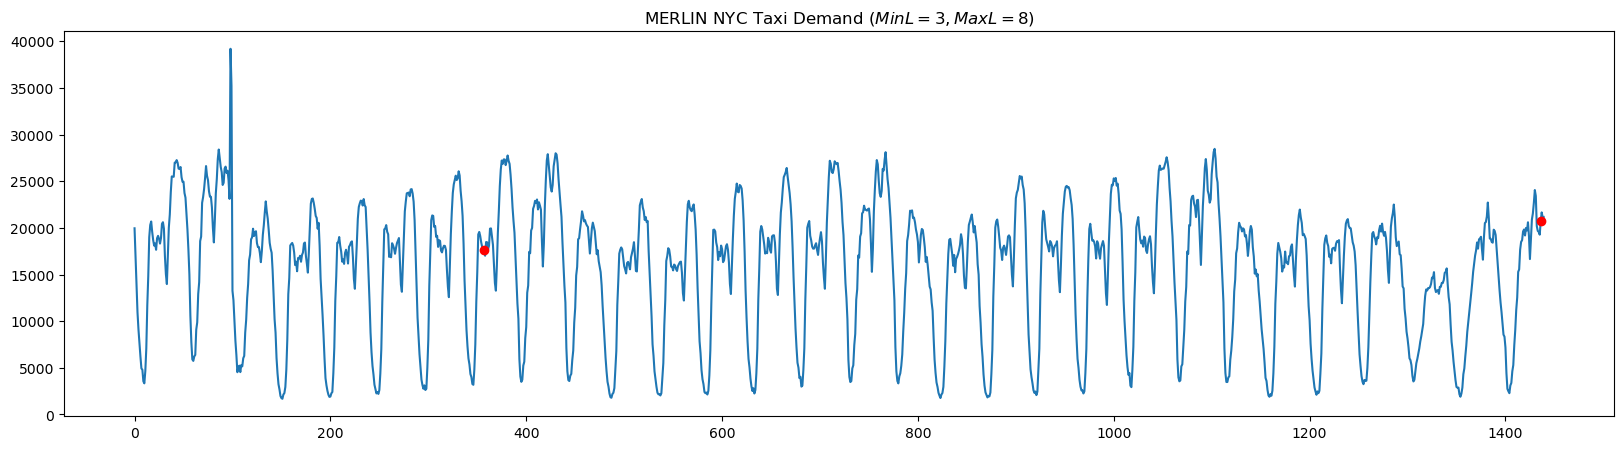

In [56]:
M = MERLIN(nyc_taxi_ts, 3, 8)
indices_merlin_nyc_taxi = M[0]
plot_time_series_with_discord(nyc_taxi_ts, indices_merlin_nyc_taxi, 'MERLIN NYC Taxi Demand ($MinL = 3, MaxL = 8$)')

In [57]:
print(f'MERLIN: {evaluate(indices_merlin_nyc_taxi, list(range(94,100)) + list(range(1297,1346)), len(nyc_taxi_ts))} %')

MERLIN: 0.0 %


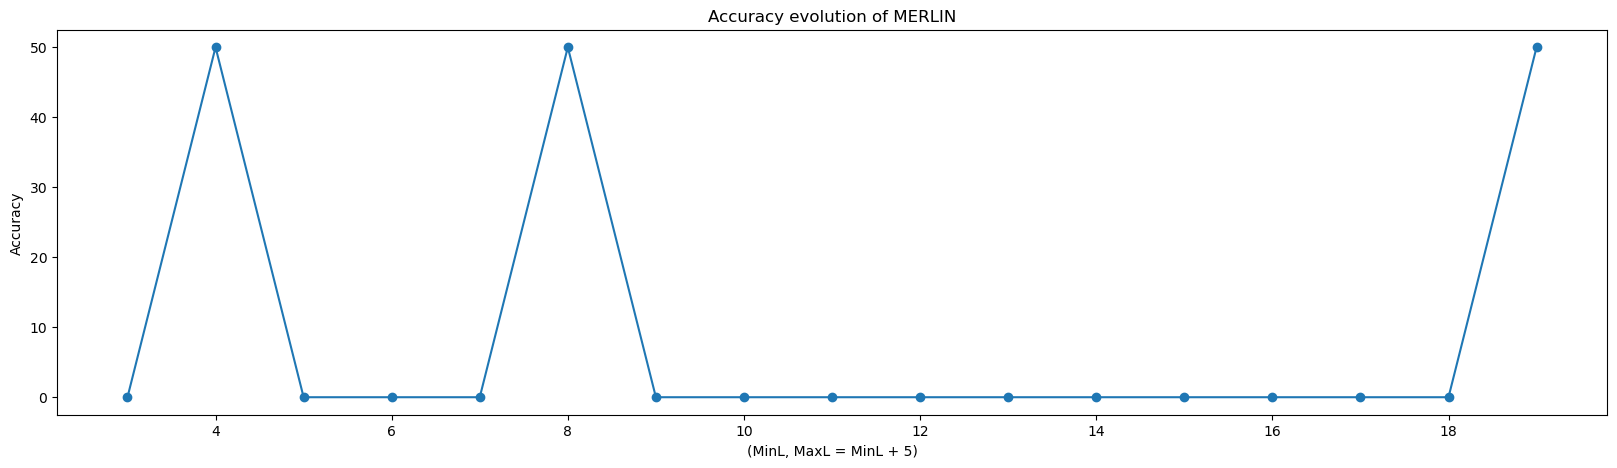

In [102]:
evaluate_plot(nyc_taxi_ts, range(3, 20), list(range(94,100)) + list(range(1297,1346))) # takes too much time (around 1 hour)

## Yahoo

### Data analysis

In [59]:
yahoo_data = pd.read_csv('yahoo.csv')

In [60]:
yahoo_data.columns

Index(['timestamp', 'value', 'is_anomaly'], dtype='object')

In [61]:
yahoo_data.head()

,timestamp,value,is_anomaly
0,1,0.000000,0
1,2,0.091758,0
2,3,0.172297,0
3,4,0.226219,0
4,5,0.176358,0


In [62]:
yahoo_data.shape

(1420, 3)

In [63]:
get_statistical_measures(yahoo_data['value'])

{'mean': 0.07970066322488706,
 'median': 0.0695212381961865,
 'std': 0.06324287862972429,
 'var': 0.003999661697374037,
 'min': 0.0,
 'max': 0.78712658620127,
 'skew': 2.2802199707026265,
 'kurtosis': 14.000263089691941,
 'quantile_25': 0.03843308710440725,
 'quantile_50': 0.0695212381961865,
 'quantile_75': 0.10587109482613251,
 'quantile_90': 0.15227132452104106}

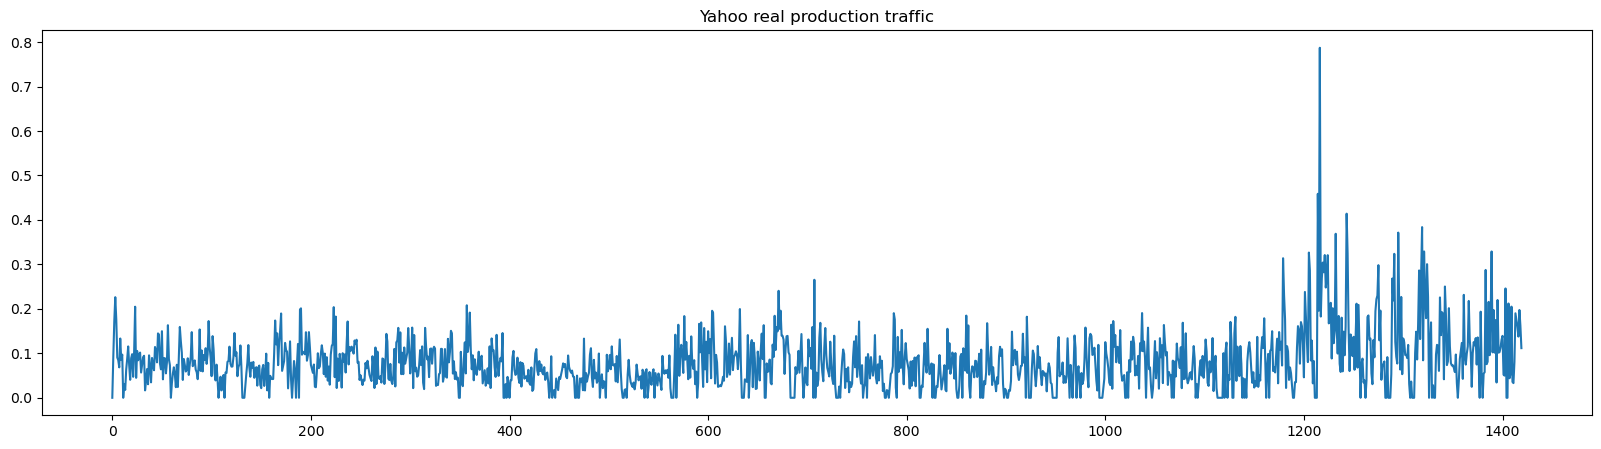

In [74]:
plot_time_series(yahoo_data['value'], 'Yahoo real production traffic')

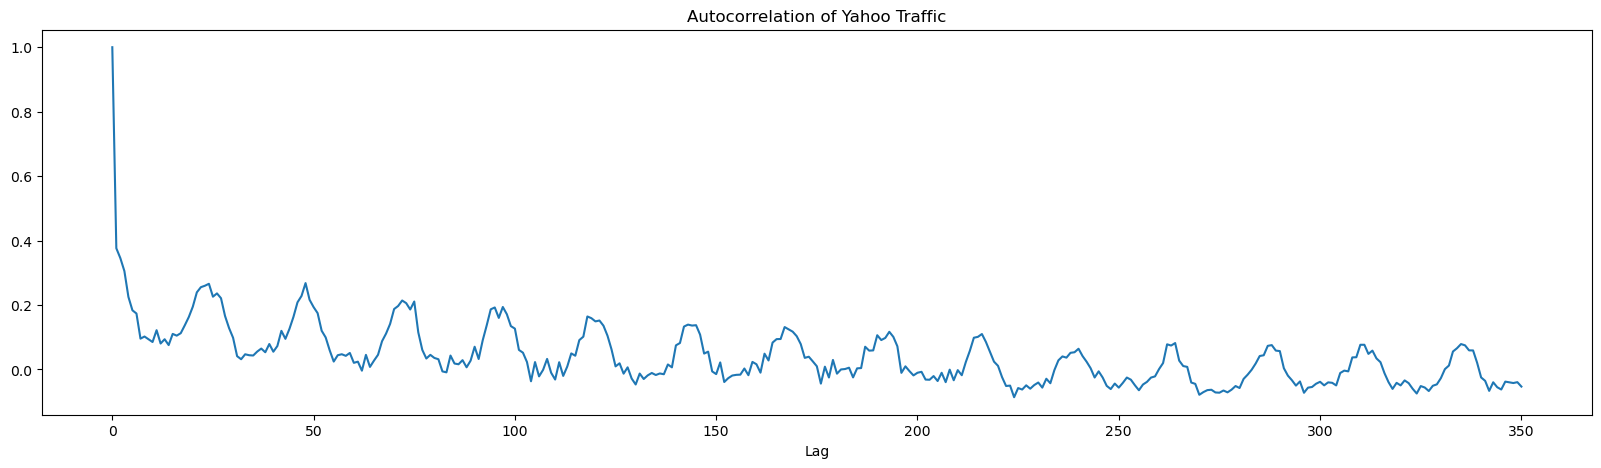

In [75]:
plot_autocorrelation(yahoo_data['value'], 'Autocorrelation of Yahoo Traffic', 350)

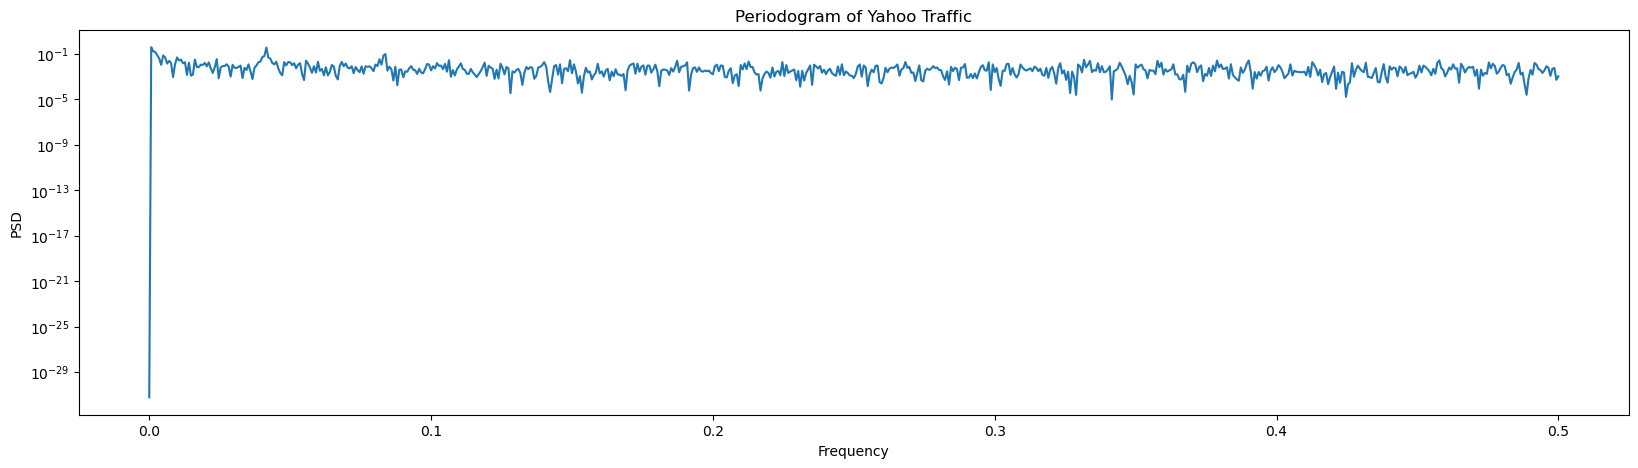

In [76]:
plot_periodogram(yahoo_data['value'], 'Periodogram of Yahoo Traffic')

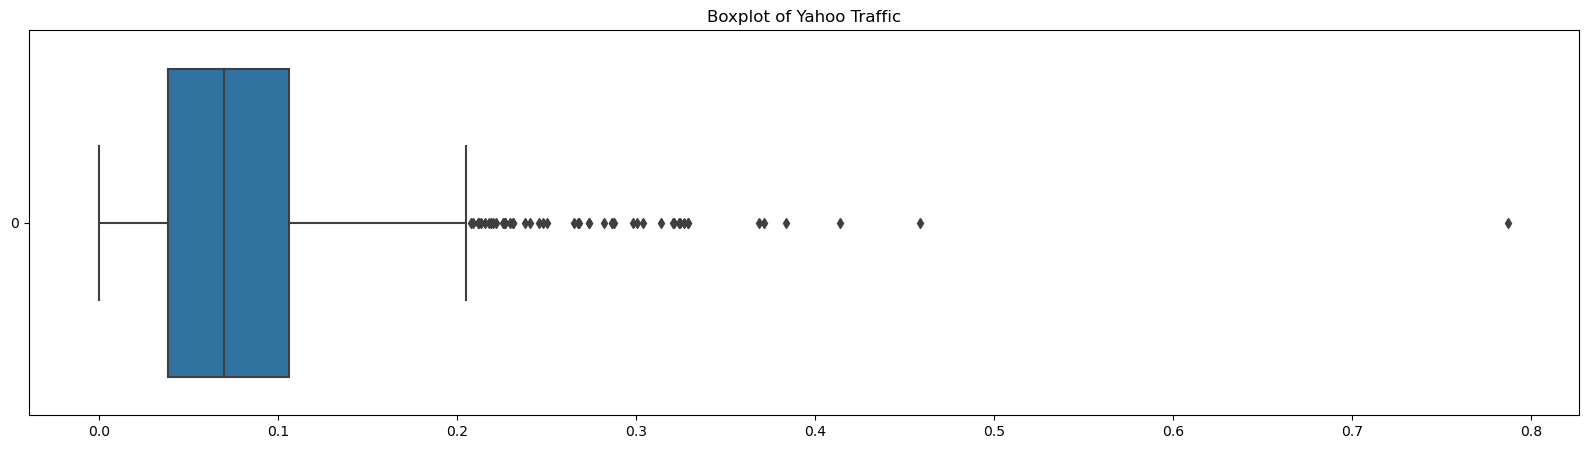

In [77]:
plot_boxplot(yahoo_data['value'], 'Boxplot of Yahoo Traffic')

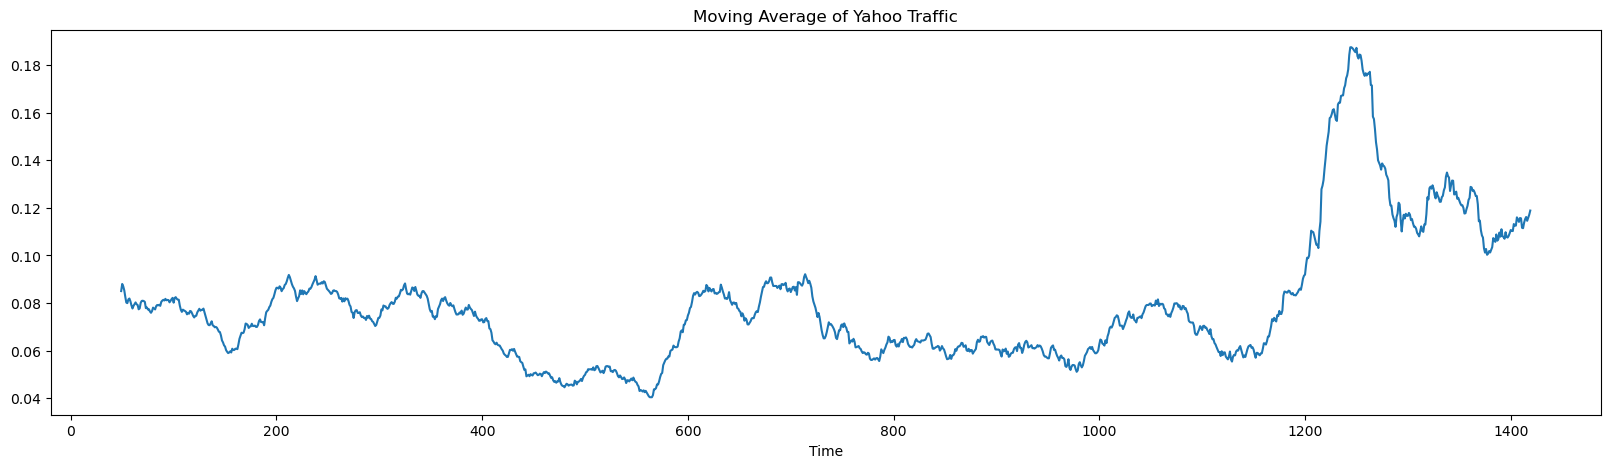

In [78]:
plot_moving_average(yahoo_data['value'], 'Moving Average of Yahoo Traffic', 50)

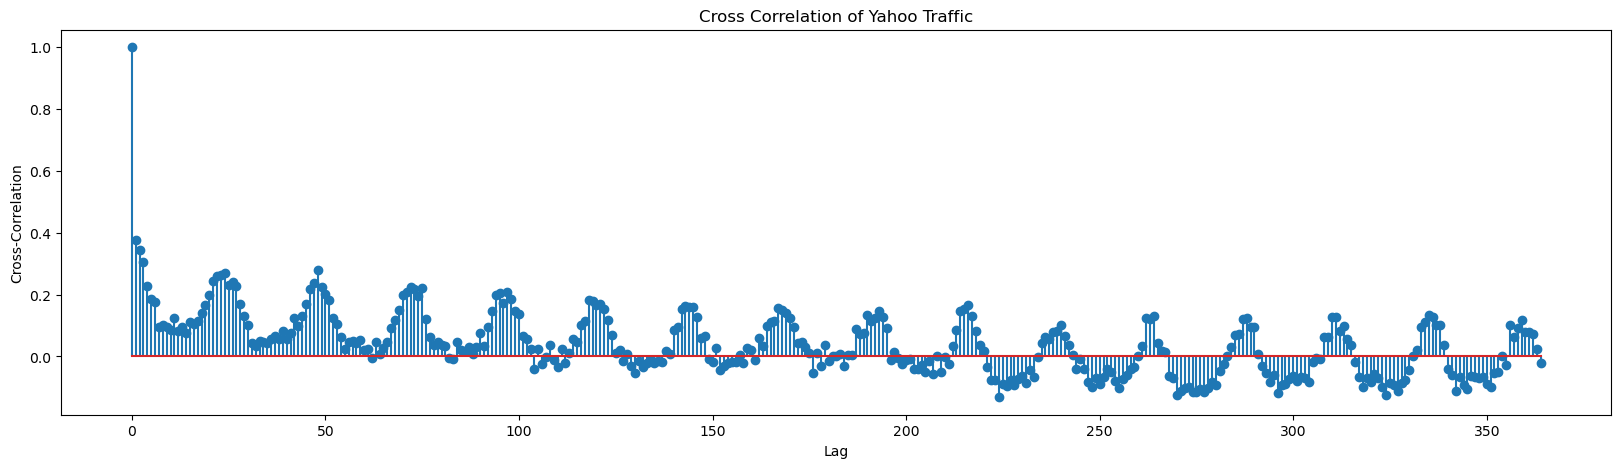

In [79]:
plot_cross_correlation(yahoo_data['value'], 'Cross Correlation of Yahoo Traffic', 365)

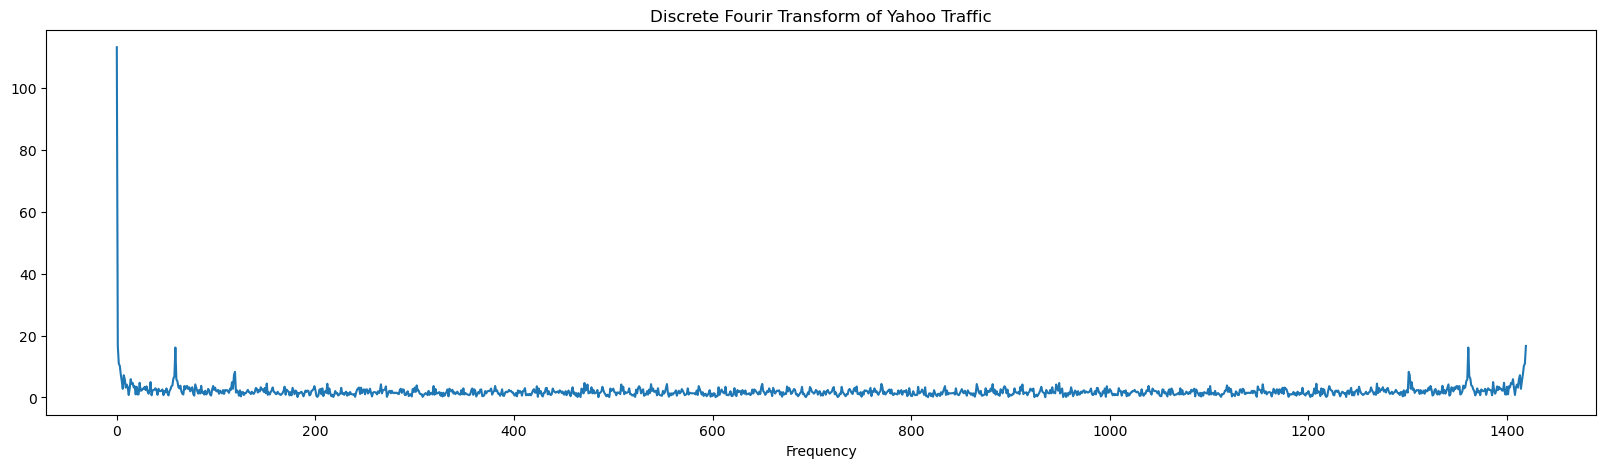

In [80]:
plot_dft(yahoo_data['value'], 'Discrete Fourir Transform of Yahoo Traffic')

### Merlin

In [81]:
yahoo_ts = yahoo_data['value'].to_numpy()

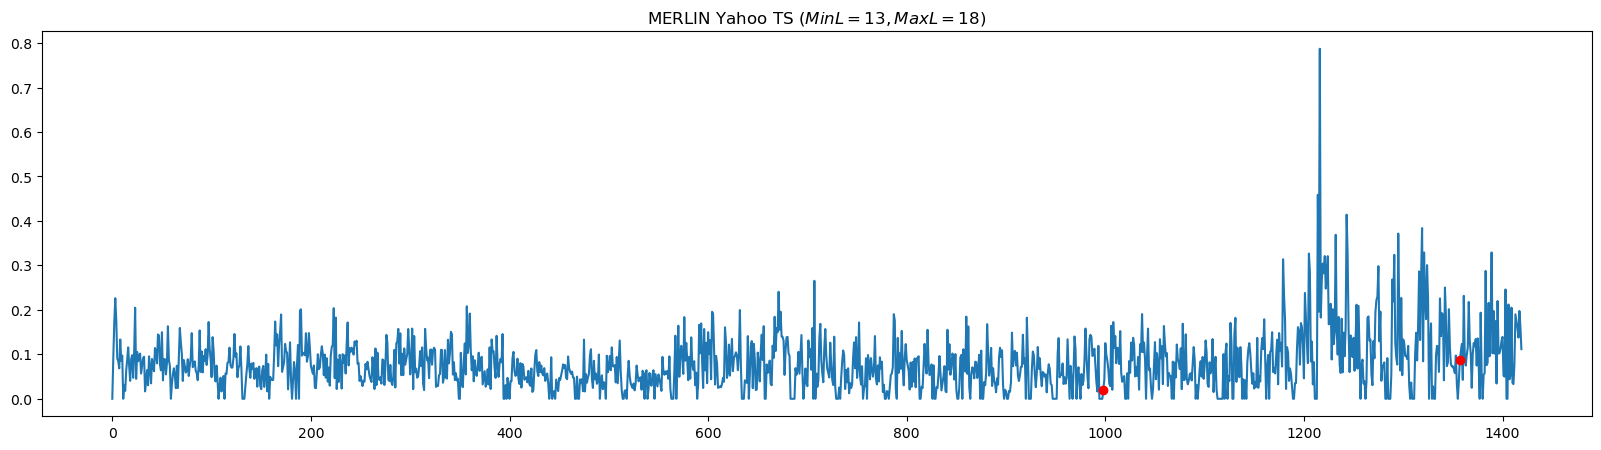

In [82]:
M = MERLIN(yahoo_ts, 13, 18)
indices_merlin_yahoo = M[0]
plot_time_series_with_discord(yahoo_ts, indices_merlin_yahoo, 'MERLIN Yahoo TS ($MinL = 13, MaxL = 18$)')

In [83]:
print(f'MERLIN: {evaluate(indices_merlin_yahoo, [1215, 1217], len(yahoo_ts))} %')

MERLIN: 0.0 %


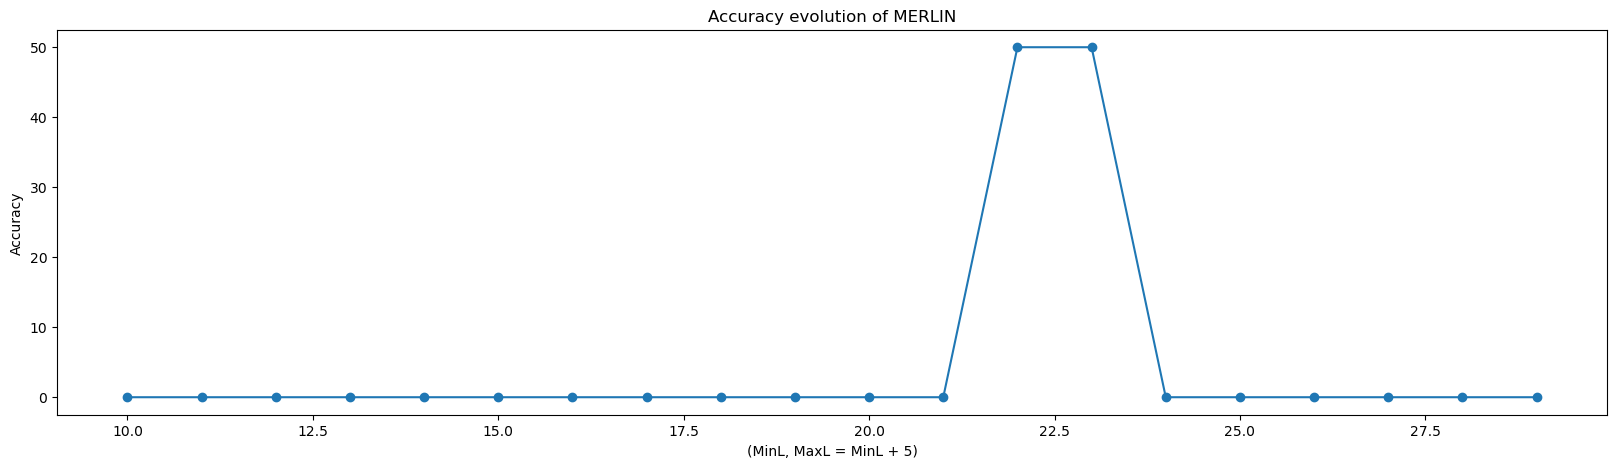

In [103]:
evaluate_plot(yahoo_ts, range(10, 30), [1215, 1217]) # takes too much time (around 1 hour)

## New Expiriments

### Ultra Subtle Anomalies

In [85]:
def generate_subtle_anomalies(T_len, anomaly_start, anomaly_end):
    T = np.zeros(T_len)
    for i in range(T_len):
        T[i] = np.sin(i/5)
    T[anomaly_start:anomaly_end] = T[anomaly_start:anomaly_end] + 0.1
    return T

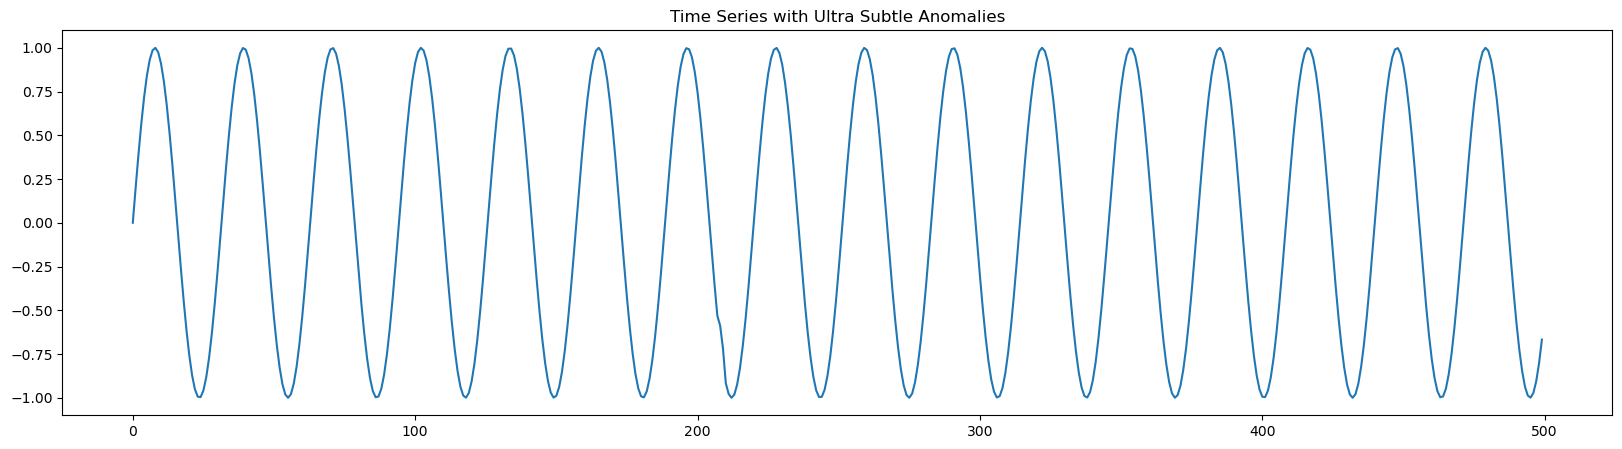

In [86]:
ultra_subtle_1 = generate_subtle_anomalies(500, 208, 210)
plot_time_series(ultra_subtle_1, 'Time Series with Ultra Subtle Anomalies')

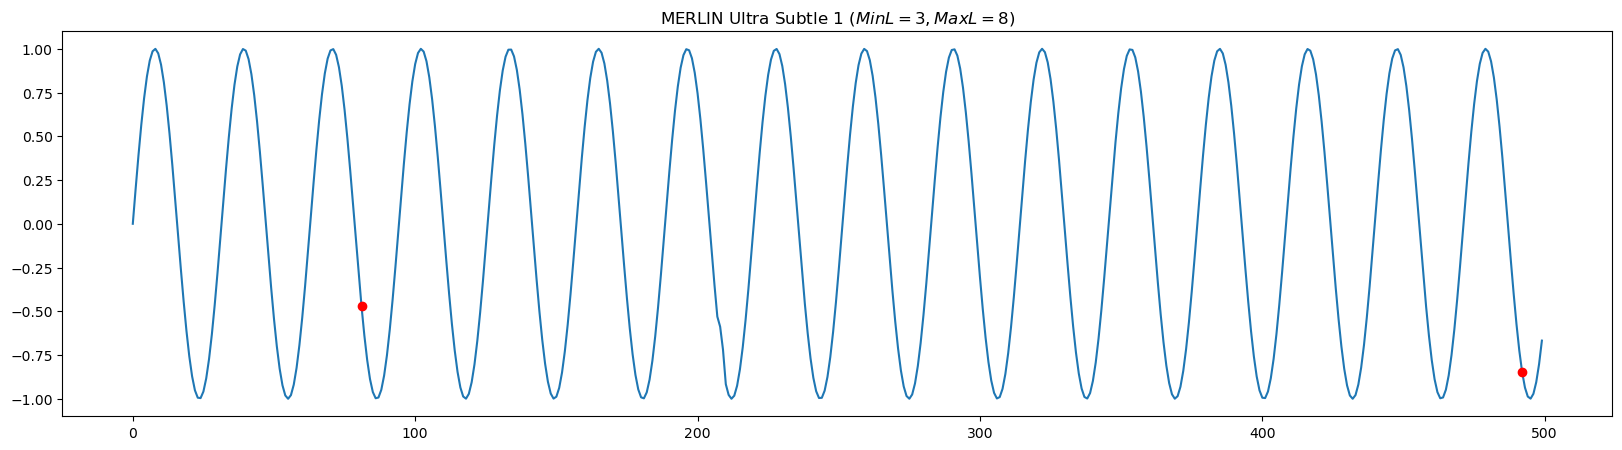

In [87]:
M = MERLIN(ultra_subtle_1, 3, 8)
indices_merlin_ultra_subtle_1 = M[0]
plot_time_series_with_discord(ultra_subtle_1, indices_merlin_ultra_subtle_1, 'MERLIN Ultra Subtle 1 ($MinL = 3, MaxL = 8$)')

In [88]:
print(f'MERLIN: {evaluate(indices_merlin_ultra_subtle_1, range(208,211), len(ultra_subtle_1))} %')

MERLIN: 0.0 %


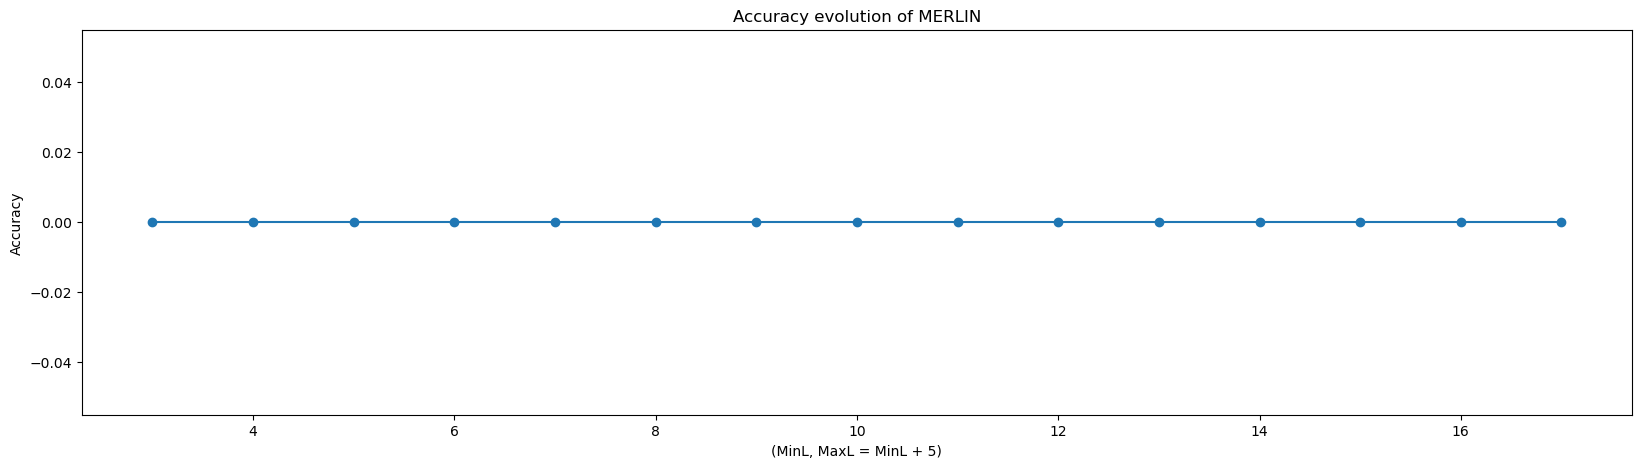

In [89]:
evaluate_plot(ultra_subtle_1, range(3, 18), range(208,211))

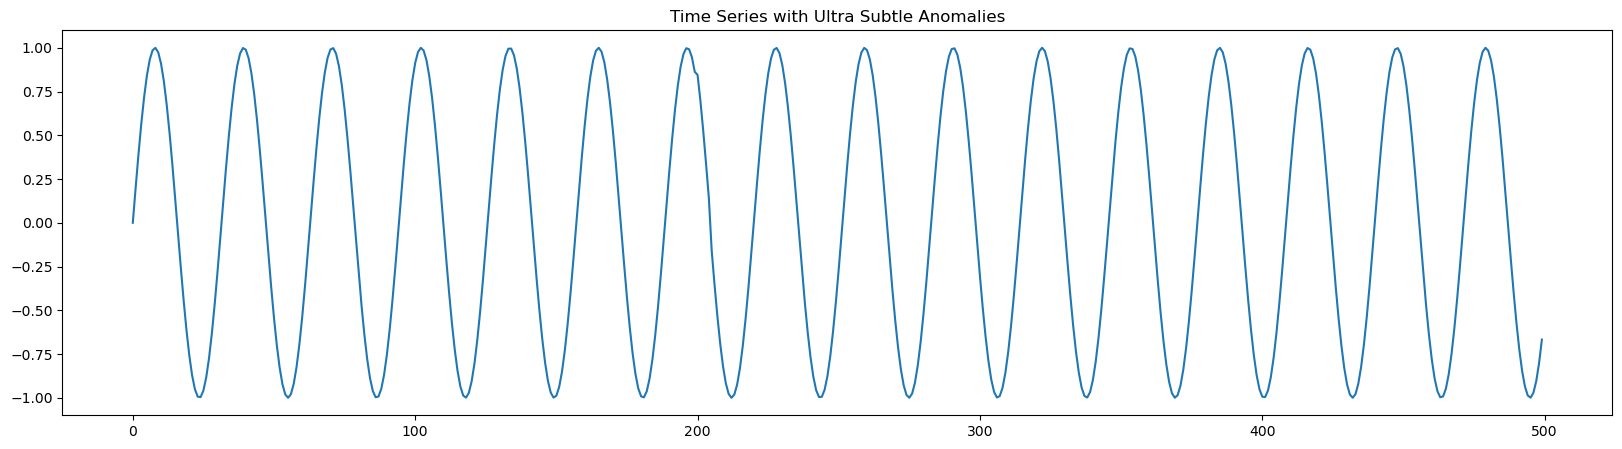

In [90]:
ultra_subtle_2 = generate_subtle_anomalies(500, 200, 205)
plot_time_series(ultra_subtle_2, 'Time Series with Ultra Subtle Anomalies')

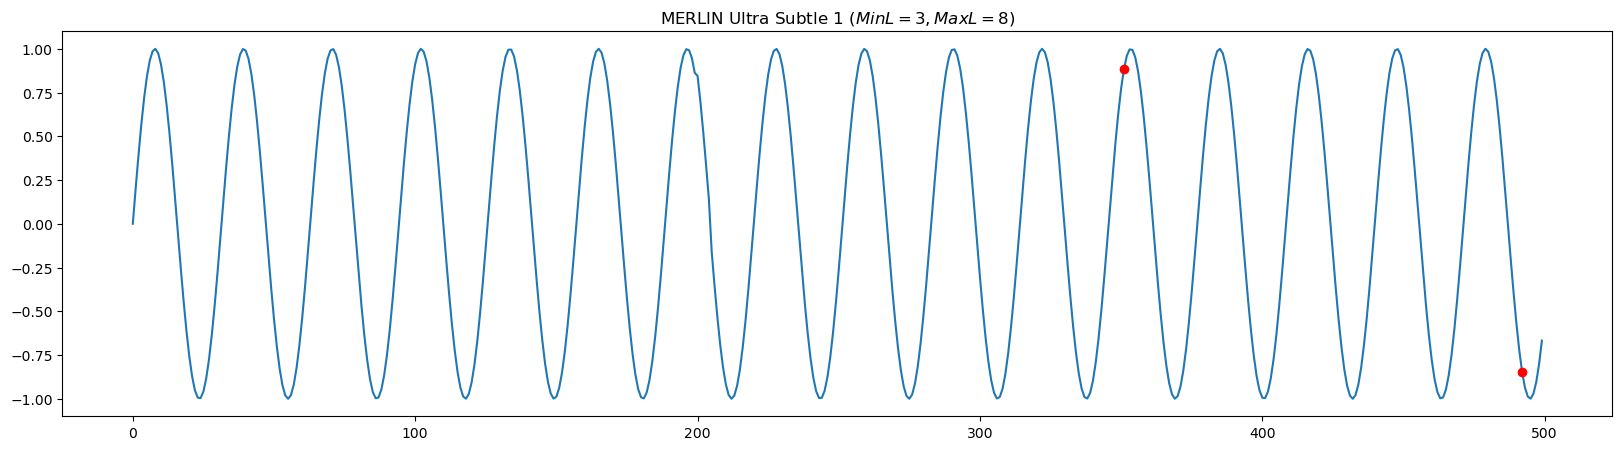

In [91]:
M = MERLIN(ultra_subtle_2, 3, 8)
indices_merlin_ultra_subtle_2 = M[0]
plot_time_series_with_discord(ultra_subtle_2, indices_merlin_ultra_subtle_2, 'MERLIN Ultra Subtle 1 ($MinL = 3, MaxL = 8$)')

In [92]:
print(f'MERLIN: {evaluate(indices_merlin_ultra_subtle_2, range(200,206), len(ultra_subtle_2))} %')

MERLIN: 0.0 %


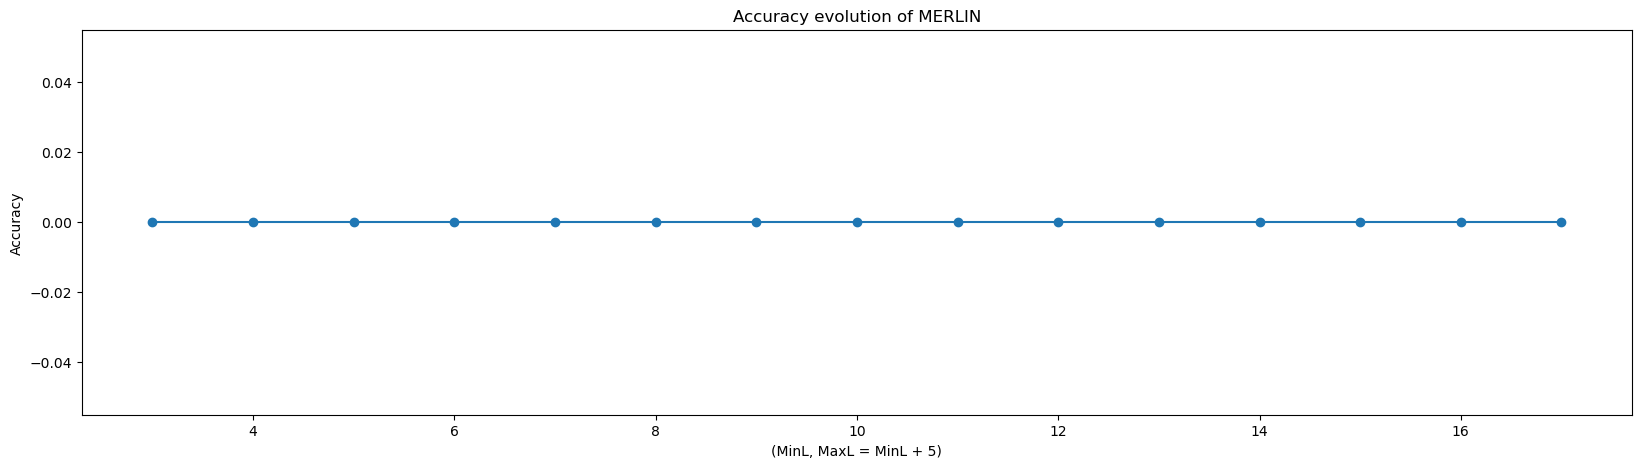

In [93]:
evaluate_plot(ultra_subtle_2, range(3, 18), range(200,206))

### Twin Freak

In [94]:
def generate_noisy_signal():
    np.random.seed(0)
    x = np.arange(1000)
    signal = np.random.normal(0, 0.3, size=x.shape)
    return x, signal

In [95]:
def add_polynomial_anomalies(signal):
    x_anomalies = [300, 700]
    for idx in x_anomalies:
        anomaly_length = 50
        x_vals = np.arange(idx, idx + anomaly_length)
        y_vals = np.polyval([0.001, 0.05, 0.1], x_vals - idx)
        signal[x_vals] += y_vals
    return signal

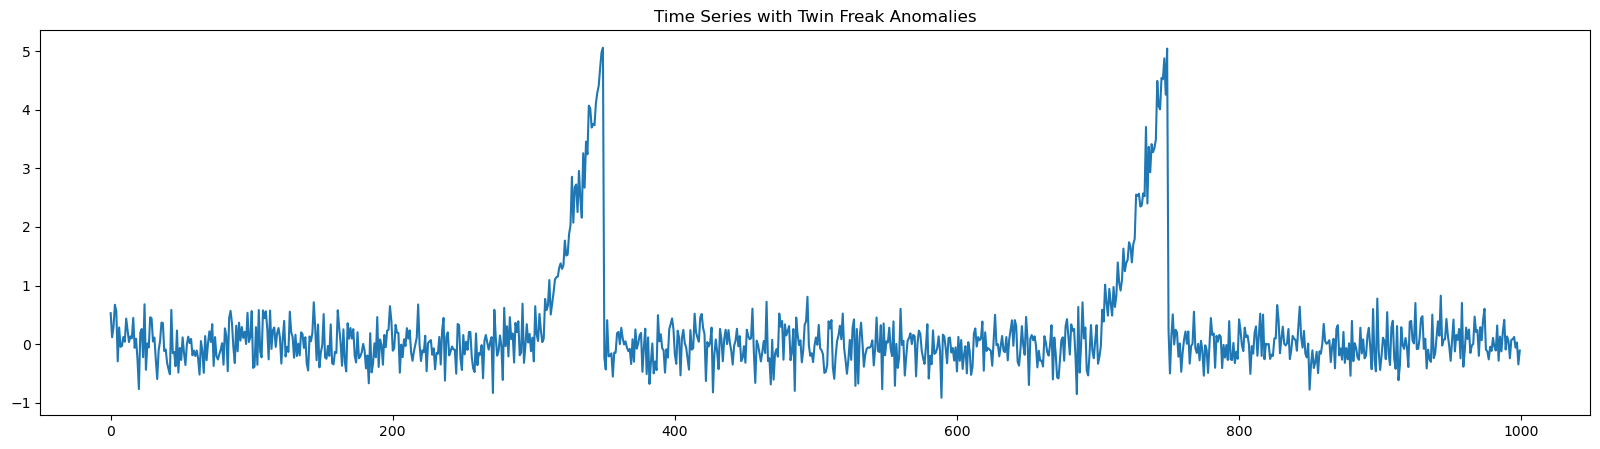

In [96]:
x, clean_signal = generate_noisy_signal()
signal_with_anomalies = add_polynomial_anomalies(clean_signal)
plot_time_series(signal_with_anomalies, 'Time Series with Twin Freak Anomalies')

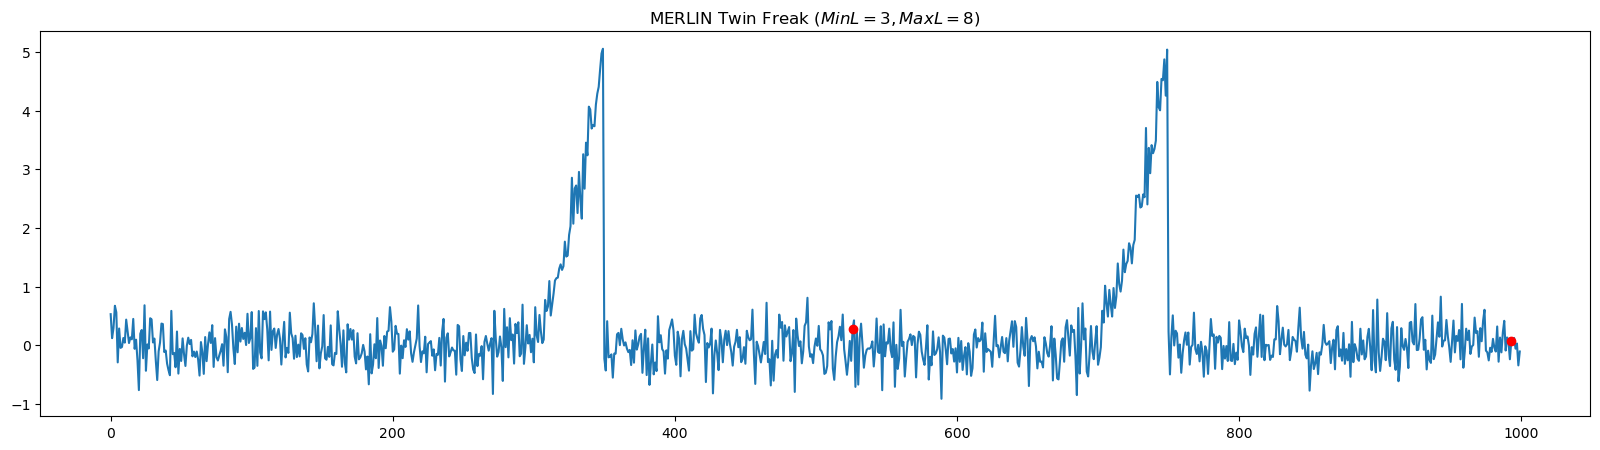

In [97]:
M = MERLIN(signal_with_anomalies, 3, 8)
indices_merlin_tf = M[0]
plot_time_series_with_discord(signal_with_anomalies, indices_merlin_tf, 'MERLIN Twin Freak ($MinL = 3, MaxL = 8$)')

In [98]:
print(f'MERLIN: {evaluate(indices_merlin_tf, list(range(300, 350)) + list(range(700, 750)), len(signal_with_anomalies))} %')

MERLIN: 0.0 %


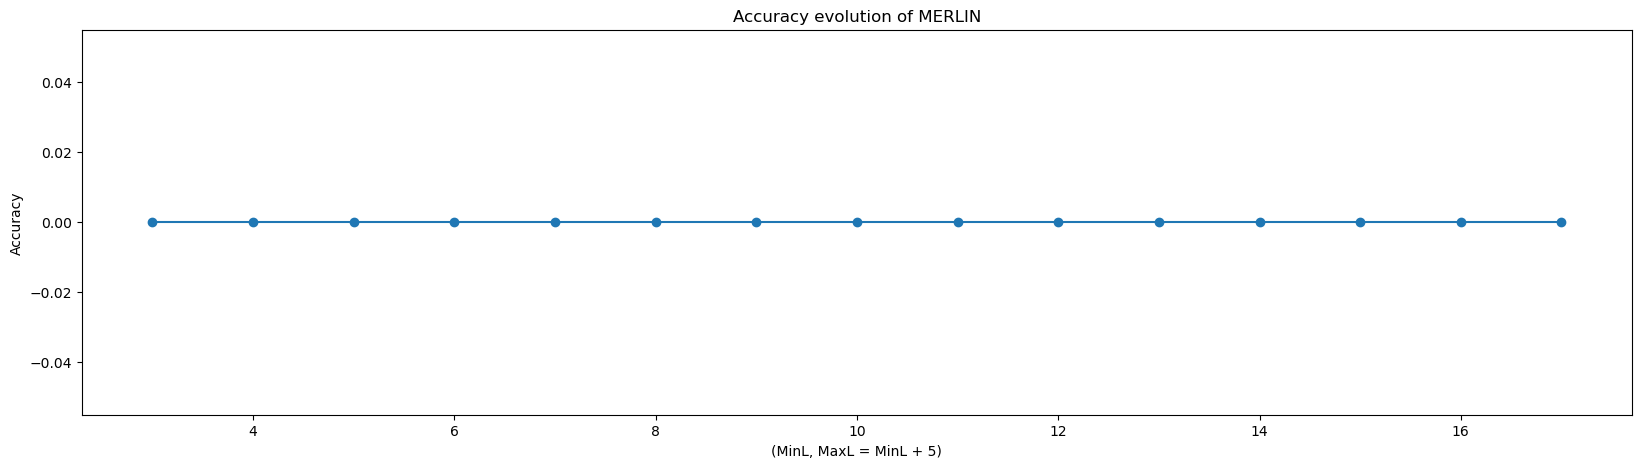

In [100]:
evaluate_plot(signal_with_anomalies, range(3, 18), list(range(300, 350)) + list(range(700, 750)))